In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import mean, std
import os, glob, matplotlib, csv

from sklearn import svm
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, hamming_loss, precision_score, classification_report, confusion_matrix, f1_score, ConfusionMatrixDisplay, zero_one_loss
from sklearn.metrics import roc_auc_score, recall_score, precision_recall_fscore_support, multilabel_confusion_matrix
from sklearn.feature_selection import RFE, SelectFromModel, SelectKBest, chi2, mutual_info_classif, RFECV
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from yellowbrick.model_selection import RFECV,FeatureImportances

from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence

##sns.set_style("whitegrid", {'axes.grid' : False})

In [3]:
mydir = '/content/drive/MyDrive/ASD+ADHD'

In [4]:
fdict = {}
count=0

for f in glob.glob(mydir + "/nsch*"):
  fdict[count] = pd.read_sas(f)
  print(f'Number of rows in file {count+1}: {fdict[count].shape[0]}')
  count+=1

Number of rows in file 1: 50212
Number of rows in file 2: 30530
Number of rows in file 3: 29433
Number of rows in file 4: 42777
Number of rows in file 5: 50892
Number of rows in file 6: 21599
Number of rows in file 7: 54103


In [ ]:
#fdict[0][~fdict[0]['RECOGBEGIN'].isna()]  #### fdict[0,1,2,3]

In [5]:
cc= fdict[0].columns.intersection(fdict[1].columns).intersection(fdict[2].columns).intersection(fdict[3].columns).intersection(
    fdict[4].columns).intersection(fdict[5].columns).intersection(fdict[6].columns)
common_cols = list(cc)

In [6]:
len(common_cols)

365

In [7]:
df = pd.concat([fdict[i][common_cols] for i in fdict.keys()])
df = df.reset_index(drop=True)
df

FIPSST         HHID FORMTYPE  TOTKIDS_R  HHLANGUAGE  SC_AGE_YEARS  \
0       b'18'  b'16000030'    b'T1'        1.0         1.0           2.0   
1       b'17'  b'16000032'    b'T2'        1.0         1.0           9.0   
2       b'50'  b'16000050'    b'T2'        1.0         1.0          11.0   
3       b'51'  b'16000051'    b'T2'        3.0         1.0          10.0   
4       b'53'  b'16000090'    b'T3'        1.0         1.0          15.0   
...       ...          ...      ...        ...         ...           ...   
279541  b'36'  b'22357530'    b'T3'        2.0         1.0          13.0   
279542  b'06'  b'22357537'    b'T2'        1.0         1.0           9.0   
279543  b'16'  b'22357539'    b'T1'        1.0         1.0           2.0   
279544  b'29'  b'22357564'    b'T2'        1.0         1.0           6.0   
279545  b'20'  b'22357567'    b'T3'        2.0         1.0          13.0   

        SC_SEX  K2Q35A_1_YEARS  MOMAGE  K6Q41R_STILL  ...  SC_RACE_R_IF  \
0          1.0             NaN    28.0           2.0  ...           NaN   
1          1.0             6.0    40.0           NaN  ...           NaN   
2          1.0             NaN    28.0           NaN  ...           NaN   
3          2.0             NaN    37.0           NaN  ...           NaN   
4          2.0             NaN    30.0           NaN  ...           NaN   
...        ...             ...     ...           ...  ...           ...   
279541     1.0             NaN    32.0           NaN  ...           0.0   
279542     2.0             NaN    25.0           NaN  ...           0.0   
279543     2.0             NaN    35.0           2.0  ...           0.0   
279544     1.0             2.0    20.0           NaN  ...           0.0   
279545     2.0             9.0    28.0           NaN  ...           0.0   

        A1_GRADE_IF  BIRTHWT  CBSAFP_YN          FWC  CURRINS  INSTYPE  \
0               NaN      3.0        2.0   847.876494      1.0      2.0   
1               NaN      3.0        1.0   873.852669      1.0      2.0   
2               NaN      3.0        NaN    47.114243      1.0      2.0   
3               NaN      3.0        1.0  1566.703779      1.0      2.0   
4               NaN      3.0        NaN   343.445947      NaN      NaN   
...             ...      ...        ...          ...      ...      ...   
279541          0.0      3.0        1.0  3133.352005      1.0      2.0   
279542          0.0      3.0        1.0   371.518119      2.0      5.0   
279543          0.0      1.0        NaN   109.054793      1.0      2.0   
279544          0.0      3.0        1.0   857.320026      1.0      NaN   
279545          0.0      3.0        1.0   895.813729      1.0      2.0   

        HOUSE_GEN  FPL_IF  INSGAP  
0             3.0     NaN     1.0  
1             3.0     NaN     1.0  
2             3.0     NaN     1.0  
3             3.0     NaN     1.0  
4             2.0     NaN     NaN  
...           ...     ...     ...  
279541        2.0     0.0     1.0  
279542        3.0     0.0     3.0  
279543        3.0     0.0     1.0  
279544        3.0     1.0     1.0  
279545        3.0     1.0     1.0  

[279546 rows x 365 columns]

In [8]:
up1 = df.drop(index = df[(df['K2Q35A'].isnull()) | (df['K2Q31A'].isnull()) | (df['K2Q38A'].isnull()) | (df['K2Q33A'].isnull()) | (df['K2Q32A'].isnull()) |
                         (df['K2Q34A'].isnull()) | (df['K2Q60A'].isnull()) | (df['K2Q37A'].isnull()) | (df['K2Q30A'].isnull()) | (df['K2Q36A'].isnull())].index.values)
up1.reset_index(drop=True, inplace=True)
up1

FIPSST         HHID FORMTYPE  TOTKIDS_R  HHLANGUAGE  SC_AGE_YEARS  \
0       b'18'  b'16000030'    b'T1'        1.0         1.0           2.0   
1       b'50'  b'16000050'    b'T2'        1.0         1.0          11.0   
2       b'51'  b'16000051'    b'T2'        3.0         1.0          10.0   
3       b'53'  b'16000090'    b'T3'        1.0         1.0          15.0   
4       b'09'  b'16000091'    b'T2'        2.0         1.0          11.0   
...       ...          ...      ...        ...         ...           ...   
270973  b'36'  b'22357530'    b'T3'        2.0         1.0          13.0   
270974  b'06'  b'22357537'    b'T2'        1.0         1.0           9.0   
270975  b'16'  b'22357539'    b'T1'        1.0         1.0           2.0   
270976  b'29'  b'22357564'    b'T2'        1.0         1.0           6.0   
270977  b'20'  b'22357567'    b'T3'        2.0         1.0          13.0   

        SC_SEX  K2Q35A_1_YEARS  MOMAGE  K6Q41R_STILL  ...  SC_RACE_R_IF  \
0          1.0             NaN    28.0           2.0  ...           NaN   
1          1.0             NaN    28.0           NaN  ...           NaN   
2          2.0             NaN    37.0           NaN  ...           NaN   
3          2.0             NaN    30.0           NaN  ...           NaN   
4          1.0             NaN    29.0           NaN  ...           NaN   
...        ...             ...     ...           ...  ...           ...   
270973     1.0             NaN    32.0           NaN  ...           0.0   
270974     2.0             NaN    25.0           NaN  ...           0.0   
270975     2.0             NaN    35.0           2.0  ...           0.0   
270976     1.0             2.0    20.0           NaN  ...           0.0   
270977     2.0             9.0    28.0           NaN  ...           0.0   

        A1_GRADE_IF  BIRTHWT  CBSAFP_YN          FWC  CURRINS  INSTYPE  \
0               NaN      3.0        2.0   847.876494      1.0      2.0   
1               NaN      3.0        NaN    47.114243      1.0      2.0   
2               NaN      3.0        1.0  1566.703779      1.0      2.0   
3               NaN      3.0        NaN   343.445947      NaN      NaN   
4               NaN      3.0        1.0   476.537806      1.0      2.0   
...             ...      ...        ...          ...      ...      ...   
270973          0.0      3.0        1.0  3133.352005      1.0      2.0   
270974          0.0      3.0        1.0   371.518119      2.0      5.0   
270975          0.0      1.0        NaN   109.054793      1.0      2.0   
270976          0.0      3.0        1.0   857.320026      1.0      NaN   
270977          0.0      3.0        1.0   895.813729      1.0      2.0   

        HOUSE_GEN  FPL_IF  INSGAP  
0             3.0     NaN     1.0  
1             3.0     NaN     1.0  
2             3.0     NaN     1.0  
3             2.0     NaN     NaN  
4             3.0     NaN     1.0  
...           ...     ...     ...  
270973        2.0     0.0     1.0  
270974        3.0     0.0     3.0  
270975        3.0     0.0     1.0  
270976        3.0     1.0     1.0  
270977        3.0     1.0     1.0  

[270978 rows x 365 columns]

In [ ]:
#up1.columns.values

In [ ]:
up1[['K6Q14A']]

K6Q14A
0          1.0
1          NaN
2          NaN
3          NaN
4          NaN
...        ...
270973     NaN
270974     NaN
270975     NaN
270976     NaN
270977     NaN

[270978 rows x 1 columns]

In [ ]:
cols_set1 = ['SC_AGE_YEARS', 'SC_SEX', 'MEMORYCOND', 'WALKSTAIRS', 'K2Q30A', 'K2Q31A', 'K2Q32A', 'K2Q33A', 'K2Q34A',
            'K2Q35A', 'K2Q36A', 'K2Q37A', 'K2Q38A', 'K2Q60A',  'K6Q71_R', 'K7Q84_R', 'K7Q85_R', 'K7Q70_R', 'MAKEFRIEND']

cols_set2 = ['SC_AGE_YEARS', 'SC_SEX', 'MEMORYCOND', 'WALKSTAIRS', 'K2Q30A', 'K2Q31A', 'K2Q32A', 'K2Q33A', 'K2Q34A',
            'K2Q35A', 'K2Q36A', 'K2Q37A', 'K2Q38A', 'K2Q60A',  'K6Q71_R', 'K7Q84_R', 'K7Q85_R', 'K7Q70_R', 'MAKEFRIEND', 'K6Q13A', 'K6Q13B', 'K6Q14A',
             'K6Q14B', 'COORDINATION', 'K6Q70_R', 'K6Q73_R', 'K6Q72_R', 'RECOGBEGIN', 'RECOGABC', 'CLEAREXP', 'WRITENAME',
             'DISTRACTED', 'PLAYWELL','HURTSAD']

In [ ]:
## 'K6Q13A', 'K6Q13B', 'K6Q14A', 'K6Q14B', 'COORDINATION', 'K6Q70_R', 'K6Q73_R', 'K6Q72_R',
## 'RECOGBEGIN', 'RECOGABC', 'CLEAREXP', 'WRITENAME','DISTRACTED', 'PLAYWELL','HURTSAD'

# study correlation - K2Q40A, K2Q41A, DOWNSYN, K2Q42A

feat_set1 = up1[(up1['MEMORYCOND'].notna()) | (up1['WALKSTAIRS'].notna()) | (up1['K7Q84_R'].notna()) | (up1['K7Q85_R'].notna()) | (up1['K7Q70_R'].notna()) |
                (up1['MAKEFRIEND'].notna()) | (up1['K6Q13A'].notna()) | (up1['K6Q13B'].notna()) | (up1['K6Q14A'].notna()) | (up1['K6Q14B'].notna()) |
                (up1['COORDINATION'].notna()) | (up1['K6Q70_R'].notna()) | (up1['K6Q73_R'].notna()) | (up1['K6Q72_R'].notna()) |  (up1['RECOGBEGIN'].notna()) |
                (up1['RECOGABC'].notna()) | (up1['CLEAREXP'].notna()) | (up1['WRITENAME'].notna()) | (up1['DISTRACTED'].notna()) | (up1['PLAYWELL'].notna()) |
                (up1['HURTSAD'].notna()) | (up1['K6Q71_R'].notna())]
feat_set1

FIPSST         HHID FORMTYPE  TOTKIDS_R  HHLANGUAGE  SC_AGE_YEARS  \
0       b'18'  b'16000030'    b'T1'        1.0         1.0           2.0   
1       b'50'  b'16000050'    b'T2'        1.0         1.0          11.0   
2       b'51'  b'16000051'    b'T2'        3.0         1.0          10.0   
3       b'53'  b'16000090'    b'T3'        1.0         1.0          15.0   
4       b'09'  b'16000091'    b'T2'        2.0         1.0          11.0   
...       ...          ...      ...        ...         ...           ...   
270973  b'36'  b'22357530'    b'T3'        2.0         1.0          13.0   
270974  b'06'  b'22357537'    b'T2'        1.0         1.0           9.0   
270975  b'16'  b'22357539'    b'T1'        1.0         1.0           2.0   
270976  b'29'  b'22357564'    b'T2'        1.0         1.0           6.0   
270977  b'20'  b'22357567'    b'T3'        2.0         1.0          13.0   

        SC_SEX  K2Q35A_1_YEARS  MOMAGE  K6Q41R_STILL  ...  SC_RACE_R_IF  \
0          1.0             NaN    28.0           2.0  ...           NaN   
1          1.0             NaN    28.0           NaN  ...           NaN   
2          2.0             NaN    37.0           NaN  ...           NaN   
3          2.0             NaN    30.0           NaN  ...           NaN   
4          1.0             NaN    29.0           NaN  ...           NaN   
...        ...             ...     ...           ...  ...           ...   
270973     1.0             NaN    32.0           NaN  ...           0.0   
270974     2.0             NaN    25.0           NaN  ...           0.0   
270975     2.0             NaN    35.0           2.0  ...           0.0   
270976     1.0             2.0    20.0           NaN  ...           0.0   
270977     2.0             9.0    28.0           NaN  ...           0.0   

        A1_GRADE_IF  BIRTHWT  CBSAFP_YN          FWC  CURRINS  INSTYPE  \
0               NaN      3.0        2.0   847.876494      1.0      2.0   
1               NaN      3.0        NaN    47.114243      1.0      2.0   
2               NaN      3.0        1.0  1566.703779      1.0      2.0   
3               NaN      3.0        NaN   343.445947      NaN      NaN   
4               NaN      3.0        1.0   476.537806      1.0      2.0   
...             ...      ...        ...          ...      ...      ...   
270973          0.0      3.0        1.0  3133.352005      1.0      2.0   
270974          0.0      3.0        1.0   371.518119      2.0      5.0   
270975          0.0      1.0        NaN   109.054793      1.0      2.0   
270976          0.0      3.0        1.0   857.320026      1.0      NaN   
270977          0.0      3.0        1.0   895.813729      1.0      2.0   

        HOUSE_GEN  FPL_IF  INSGAP  
0             3.0     NaN     1.0  
1             3.0     NaN     1.0  
2             3.0     NaN     1.0  
3             2.0     NaN     NaN  
4             3.0     NaN     1.0  
...           ...     ...     ...  
270973        2.0     0.0     1.0  
270974        3.0     0.0     3.0  
270975        3.0     0.0     1.0  
270976        3.0     1.0     1.0  
270977        3.0     1.0     1.0  

[270940 rows x 365 columns]

K6Q13A - talks or speech concerns; K6Q13B - interaction concerns; K6Q14A - words and phrases concerns; K6Q14B - behaves and gets along concerns;

COORDINATION - difficulty coordinating or moving around; K6Q70_R - is affectionate and tender; K6Q73_R - Bounces Back if things do not go their way; K6Q72_R - Smiles and Laughs

RECOGBEGIN - Recognize Beginning Sound of a Word; RECOGABC - Recognize Letters of Alphabet; CLEAREXP - How Often - Explain Things Good Idea; WRITENAME - How Often - Write First Name; DISTRACTED - How Often - Easily Distracted; PLAYWELL - How Often - Play Well with Others; HURTSAD - How Often - Show Concern

MEMORYCOND -  Serious Difficulty Concentrating, Remembering, or Making Decisions; WALKSTAIRS - - Serious Difficulty Walking or Climbing Stairs; K6Q71_R - Interest Curiosity; K7Q84_R - Works to Finish Tasks Started; K7Q85_R - Stays Calm and In Control When Challenged; K7Q70_R - Argues Too Much; MAKEFRIEND

In [ ]:
feat_set1_df = feat_set1[cols_set2]

In [ ]:
'''
na_val = ['MEMORYCOND', 'WALKSTAIRS', 'DRESSING', 'K6Q71_R', 'K7Q84_R', 'K7Q85_R', 'K7Q70_R', 'MAKEFRIEND', 'K6Q13A', 'K6Q13B', 'K6Q14A',
             'K6Q14B', 'COORDINATION', 'K6Q70_R', 'K6Q73_R', 'K6Q72_R', 'K7Q82_R', 'K7Q83_R', 'RECOGBEGIN', 'RECOGABC', 'CLEAREXP', 'WRITENAME',
             'DISTRACTED', 'PLAYWELL','HURTSAD']

temp_df = pd.DataFrame()
dummy = pd.DataFrame()

for c in na_val:
  dummy = feat_set1_df[~feat_set1_df.index.isin(temp_df.index)]
  temp_df = pd.concat([temp_df, dummy[dummy[c].notna()]])
'''

In [ ]:
test1 = up1[cols_set2]
print(test1.shape)
print('\n')

for c in test1.columns:
  print(f'NA values in column: {c} = {test1[c].isna().sum()}')

(270978, 34)


NA values in column: SC_AGE_YEARS = 0
NA values in column: SC_SEX = 0
NA values in column: MEMORYCOND = 89246
NA values in column: WALKSTAIRS = 89320
NA values in column: K2Q30A = 0
NA values in column: K2Q31A = 0
NA values in column: K2Q32A = 0
NA values in column: K2Q33A = 0
NA values in column: K2Q34A = 0
NA values in column: K2Q35A = 0
NA values in column: K2Q36A = 0
NA values in column: K2Q37A = 0
NA values in column: K2Q38A = 0
NA values in column: K2Q60A = 0
NA values in column: K6Q71_R = 2320
NA values in column: K7Q84_R = 90512
NA values in column: K7Q85_R = 90164
NA values in column: K7Q70_R = 90149
NA values in column: MAKEFRIEND = 53013
NA values in column: K6Q13A = 264759
NA values in column: K6Q13B = 264759
NA values in column: K6Q14A = 246280
NA values in column: K6Q14B = 246280
NA values in column: COORDINATION = 183809
NA values in column: K6Q70_R = 184209
NA values in column: K6Q73_R = 184277
NA values in column: K6Q72_R = 184158
NA values in column: RE

In [ ]:
test1.columns

Index(['SC_AGE_YEARS', 'SC_SEX', 'MEMORYCOND', 'WALKSTAIRS', 'K2Q30A',
       'K2Q31A', 'K2Q32A', 'K2Q33A', 'K2Q34A', 'K2Q35A', 'K2Q36A', 'K2Q37A',
       'K2Q38A', 'K2Q60A', 'K6Q71_R', 'K7Q84_R', 'K7Q85_R', 'K7Q70_R',
       'MAKEFRIEND', 'K6Q13A', 'K6Q13B', 'K6Q14A', 'K6Q14B', 'COORDINATION',
       'K6Q70_R', 'K6Q73_R', 'K6Q72_R', 'RECOGBEGIN', 'RECOGABC', 'CLEAREXP',
       'WRITENAME', 'DISTRACTED', 'PLAYWELL', 'HURTSAD'],
      dtype='object')

In [ ]:
##%rm testfile*.csv

In [ ]:
stats = {'a': 1, 'b': 3000, 'c': 0}
max(stats, key=stats.get)

'b'

In [ ]:
test_cols = ['MEMORYCOND', 'WALKSTAIRS', 'K6Q71_R', 'K7Q84_R', 'K7Q85_R', 'K7Q70_R', 'MAKEFRIEND', 'K6Q13A', 'K6Q13B', 'K6Q14A', 'K6Q14B', 'COORDINATION',
       'K6Q70_R', 'K6Q73_R', 'K6Q72_R', 'RECOGBEGIN', 'RECOGABC', 'CLEAREXP', 'WRITENAME', 'DISTRACTED', 'PLAYWELL', 'HURTSAD']

for i in range(len(test_cols)-1):
  for j in range(i+1, len(test_cols)):
    drop_max = test1[(test1[test_cols[i]].notna()) & (test1[test_cols[j]].notna())]
    print('\n')
    print(drop_max.shape)
    print(f'Testing columns: {test_cols[i], test_cols[j]}')
    #pd.DataFrame(drop_max.isna().sum().to_dict(), index=[0]).to_csv(f'testfile{i:02}.csv')
    print(dict(drop_max.isna().sum()))
    print(f'Column with max null values: {max(dict(drop_max.isna().sum()), key=dict(drop_max.isna().sum()).get)}')



(181178, 34)
Testing columns: ('MEMORYCOND', 'WALKSTAIRS')
{'SC_AGE_YEARS': 0, 'SC_SEX': 0, 'MEMORYCOND': 0, 'WALKSTAIRS': 0, 'K2Q30A': 0, 'K2Q31A': 0, 'K2Q32A': 0, 'K2Q33A': 0, 'K2Q34A': 0, 'K2Q35A': 0, 'K2Q36A': 0, 'K2Q37A': 0, 'K2Q38A': 0, 'K2Q60A': 0, 'K6Q71_R': 1346, 'K7Q84_R': 1854, 'K7Q85_R': 1506, 'K7Q70_R': 1494, 'MAKEFRIEND': 1440, 'K6Q13A': 181178, 'K6Q13B': 181178, 'K6Q14A': 181178, 'K6Q14B': 181178, 'COORDINATION': 181178, 'K6Q70_R': 181178, 'K6Q73_R': 181178, 'K6Q72_R': 181178, 'RECOGBEGIN': 181178, 'RECOGABC': 181178, 'CLEAREXP': 181178, 'WRITENAME': 181178, 'DISTRACTED': 181178, 'PLAYWELL': 181178, 'HURTSAD': 181178}
Column with max null values: K6Q13A


(180376, 34)
Testing columns: ('MEMORYCOND', 'K6Q71_R')
{'SC_AGE_YEARS': 0, 'SC_SEX': 0, 'MEMORYCOND': 0, 'WALKSTAIRS': 544, 'K2Q30A': 0, 'K2Q31A': 0, 'K2Q32A': 0, 'K2Q33A': 0, 'K2Q34A': 0, 'K2Q35A': 0, 'K2Q36A': 0, 'K2Q37A': 0, 'K2Q38A': 0, 'K2Q60A': 0, 'K6Q71_R': 0, 'K7Q84_R': 849, 'K7Q85_R': 510, 'K7Q70_R': 507, 'M

In [ ]:
#drop_max = test1[(test1['K6Q13A'].notna()) & (test1['K6Q13B'].notna())]
##pd.DataFrame(drop_max.isna().sum().to_dict(), index=[0]).to_csv('test.csv')

#a = drop_max.isna().sum().to_dict()

#with open('test.csv', 'w') as csv_file:
#    writer = csv.writer(csv_file)
#    for key, value in a.items():
#       writer.writerow([key, value])

In [ ]:
##'K7Q30','K7Q31','K7Q32','K7Q37','K7Q38','K7Q82_R','K7Q83_R','K7Q02R_R','K7Q04R_R','PHYSACTIV','HOURSLEEP','HCABILITY,'K4Q23','K8Q21','SC_K2Q19','SC_K2Q22','K7Q82_R', 'K7Q83_R',

In [9]:
feat1 = ['SC_AGE_YEARS', 'SC_SEX', 'K2Q30A', 'K2Q31A', 'K2Q32A', 'K2Q33A', 'K2Q34A', 'K2Q35A', 'K2Q36A', 'K2Q37A','K2Q38A', 'K2Q60A',
         'MEMORYCOND', 'WALKSTAIRS',  'K6Q71_R', 'K7Q84_R', 'K7Q85_R', 'K7Q70_R', 'MAKEFRIEND']

feat2 = ['SC_AGE_YEARS', 'SC_SEX', 'K2Q30A', 'K2Q31A', 'K2Q32A', 'K2Q33A', 'K2Q34A', 'K2Q35A', 'K2Q36A', 'K2Q37A','K2Q38A', 'K2Q60A',
         'K6Q13A', 'K6Q13B', 'K6Q71_R', 'COORDINATION', 'K6Q70_R', 'K6Q73_R', 'K6Q72_R']

feat3 = ['SC_AGE_YEARS', 'SC_SEX', 'K2Q30A', 'K2Q31A', 'K2Q32A', 'K2Q33A', 'K2Q34A', 'K2Q35A', 'K2Q36A', 'K2Q37A','K2Q38A', 'K2Q60A',
         'K6Q71_R', 'MAKEFRIEND', 'COORDINATION', 'K6Q70_R', 'K6Q73_R', 'K6Q72_R', 'RECOGBEGIN', 'RECOGABC', 'CLEAREXP',
         'WRITENAME', 'DISTRACTED', 'PLAYWELL', 'HURTSAD']    ## removed 'K6Q14A' and 'K6Q14B

df1 = up1[feat1]
df2 = up1[feat2]
df3 = up1[feat3]

In [10]:
print(f'{df1.shape} \n{df1.isna().sum()} \n')

print(f'{df2.shape} \n{df2.isna().sum()} \n')

print(f'{df3.shape} \n{df3.isna().sum()} \n')

(270978, 19) 
SC_AGE_YEARS        0
SC_SEX              0
K2Q30A              0
K2Q31A              0
K2Q32A              0
K2Q33A              0
K2Q34A              0
K2Q35A              0
K2Q36A              0
K2Q37A              0
K2Q38A              0
K2Q60A              0
MEMORYCOND      89246
WALKSTAIRS      89320
K6Q71_R          2320
K7Q84_R         90512
K7Q85_R         90164
K7Q70_R         90149
MAKEFRIEND      53013
dtype: int64 

(270978, 19) 
SC_AGE_YEARS         0
SC_SEX               0
K2Q30A               0
K2Q31A               0
K2Q32A               0
K2Q33A               0
K2Q34A               0
K2Q35A               0
K2Q36A               0
K2Q37A               0
K2Q38A               0
K2Q60A               0
K6Q13A          264759
K6Q13B          264759
K6Q71_R           2320
COORDINATION    183809
K6Q70_R         184209
K6Q73_R         184277
K6Q72_R         184158
dtype: int64 

(270978, 25) 
SC_AGE_YEARS         0
SC_SEX               0
K2Q30A               0
K2Q3

In [11]:
updated_df1 = df1.dropna()
updated_df2 = df2.dropna()
updated_df3 = df3.dropna()

print(updated_df1.shape, updated_df2.shape, updated_df3.shape)

#print(updated_df1.isna().any(), updated_df2.isna().any(), updated_df3.isna().any())

(177356, 19) (6158, 19) (35889, 25)


## Basic statistics

In [ ]:
## overall mean age of the child in the data

up1['SC_AGE_YEARS'].mean()

9.03356361032999

Text(32.98128858024692, 0.5, 'Number of children with ASD only')

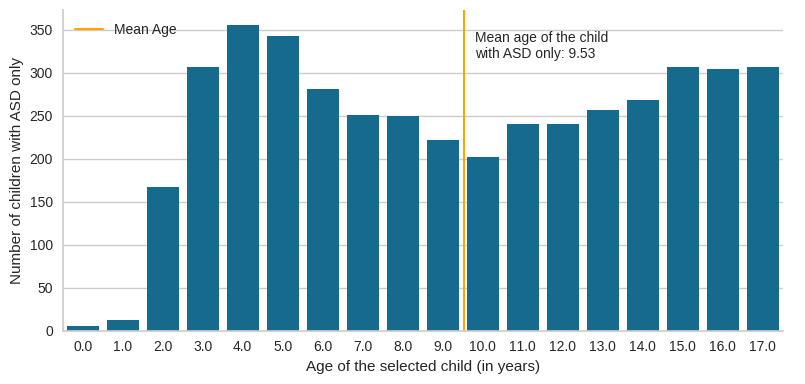

In [ ]:
sns.catplot(data=up1[(up1['K2Q35A']==1) & (up1['K2Q31A']==2)], x='SC_AGE_YEARS',kind='count', height=4, aspect=2)
mean_asd = up1[(up1['K2Q35A']==1) & (up1['K2Q31A']==2)]['SC_AGE_YEARS'].mean()
plt.axvline(mean_asd, color='orange', label='Mean Age', linewidth=1.5)
min_ylim, max_ylim = plt.ylim()
plt.text(mean_asd*1.03, max_ylim*0.85, 'Mean age of the child\nwith ASD only: {:.2f}'.format(mean_asd), fontsize='small')
plt.legend(loc='upper left')
plt.xlabel('Age of the selected child (in years)')
plt.ylabel('Number of children with ASD only')

Text(33.0889274691358, 0.5, 'Number of children with ADHD only')

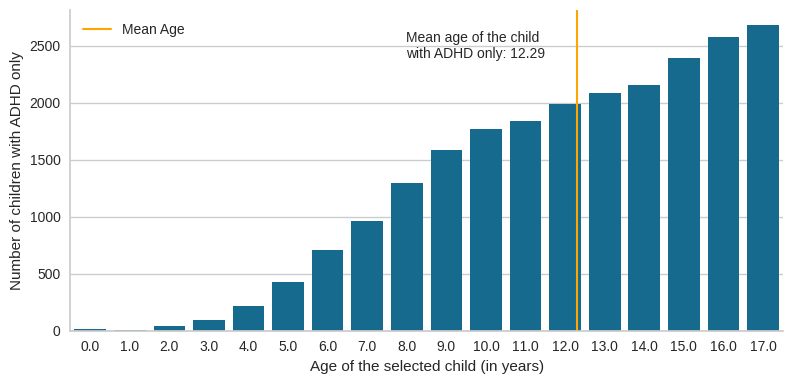

In [ ]:
sns.catplot(data=up1[(up1['K2Q35A']==2) & (up1['K2Q31A']==1)], x='SC_AGE_YEARS',kind='count', height=4, aspect=2)
mean_adhd = up1[(up1['K2Q35A']==2) & (up1['K2Q31A']==1)]['SC_AGE_YEARS'].mean()
plt.axvline(mean_adhd, color='orange', label='Mean Age', linewidth=1.5)
min_ylim, max_ylim = plt.ylim()
plt.text(mean_adhd*0.65, max_ylim*0.85, 'Mean age of the child\nwith ADHD only: {:.2f}'.format(mean_adhd), fontsize='small')
plt.legend()
plt.xlabel('Age of the selected child (in years)')
plt.ylabel('Number of children with ADHD only')

Text(32.9345605526161, 0.5, 'Number of children with both ASD and ADHD ')

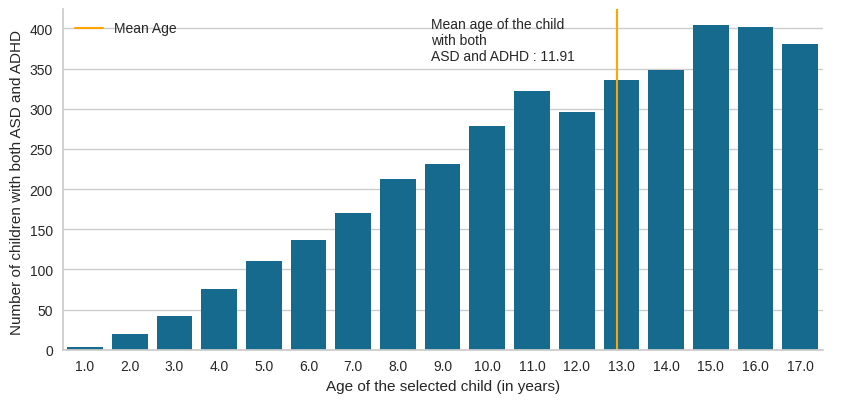

In [ ]:
sns.catplot(data=up1[(up1['K2Q35A']==1) & (up1['K2Q31A']==1)], x='SC_AGE_YEARS',kind='count', height=4.2, aspect=2)
mean_both = up1[(up1['K2Q35A']==1) & (up1['K2Q31A']==1)]['SC_AGE_YEARS'].mean()
plt.axvline(mean_both, color='orange', label='Mean Age', linewidth=1.5)
min_ylim, max_ylim = plt.ylim()
plt.text(mean_both*0.65, max_ylim*0.85, 'Mean age of the child\nwith both\nASD and ADHD : {:.2f}'.format(mean_both), fontsize='small')
plt.legend()
plt.xlabel('Age of the selected child (in years)')
plt.ylabel('Number of children with both ASD and ADHD ')

In [ ]:
## gender demographics

gen = ['Male', 'Female']

for i in range(1,3):
  print(f"Gender: {gen[i-1]} - ASD only: {up1[(up1['K2Q35A']==1) & (up1['K2Q31A']==2) & (up1['SC_SEX']==i)].shape[0]}")
  print(f"Gender: {gen[i-1]} - ADHD only: {up1[(up1['K2Q35A']==2) & (up1['K2Q31A']==1) & (up1['SC_SEX']==i)].shape[0]}")
  print(f"Gender: {gen[i-1]} - ASD and ADHD: {up1[(up1['K2Q35A']==1) & (up1['K2Q31A']==1) & (up1['SC_SEX']==i)].shape[0]}")
  print("\n")

Gender: Male - ASD only: 3344
Gender: Male - ADHD only: 15023
Gender: Male - ASD and ADHD: 2997


Gender: Female - ASD only: 971
Gender: Female - ADHD only: 7840
Gender: Female - ASD and ADHD: 773




In [ ]:
## total male and female
up1['SC_SEX'].value_counts()

1.0    140233
2.0    130745
Name: SC_SEX, dtype: int64

Text(0.5, 0.98, 'Gender distribution')

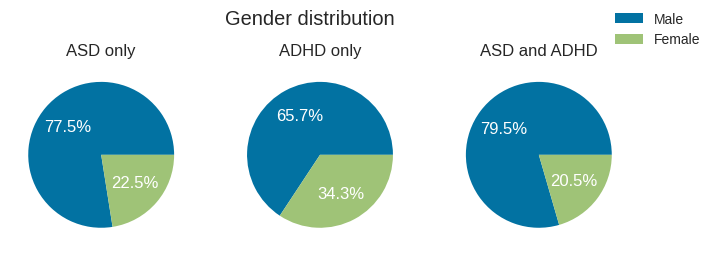

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8,3))
ax1.pie(up1[(up1['K2Q35A']==1) & (up1['K2Q31A']==2)]['SC_SEX'].value_counts(), autopct='%.1f%%',textprops={'color':"w"})
ax1.set_title('ASD only')
ax2.pie(up1[(up1['K2Q35A']==2) & (up1['K2Q31A']==1)]['SC_SEX'].value_counts(), autopct='%.1f%%',textprops={'color':"w"})
ax2.set_title('ADHD only')
ax3.pie(up1[(up1['K2Q35A']==1) & (up1['K2Q31A']==1)]['SC_SEX'].value_counts(), autopct='%.1f%%',textprops={'color':"w"})
ax3.set_title('ASD and ADHD')

fig.legend(['Male', 'Female'])
fig.suptitle('Gender distribution')

In [ ]:
up1[(up1['K2Q35A']==1) & (up1['K2Q31A']==2)]['SC_RACE_R'].value_counts()

1.0    3167
7.0     430
2.0     370
4.0     239
6.0      44
3.0      43
5.0      22
Name: SC_RACE_R, dtype: int64

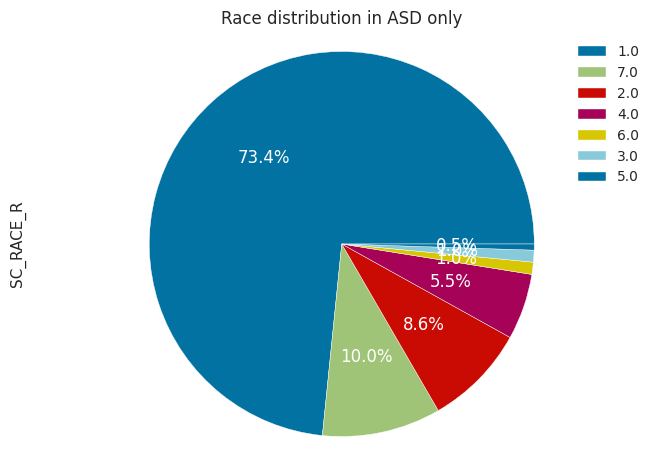

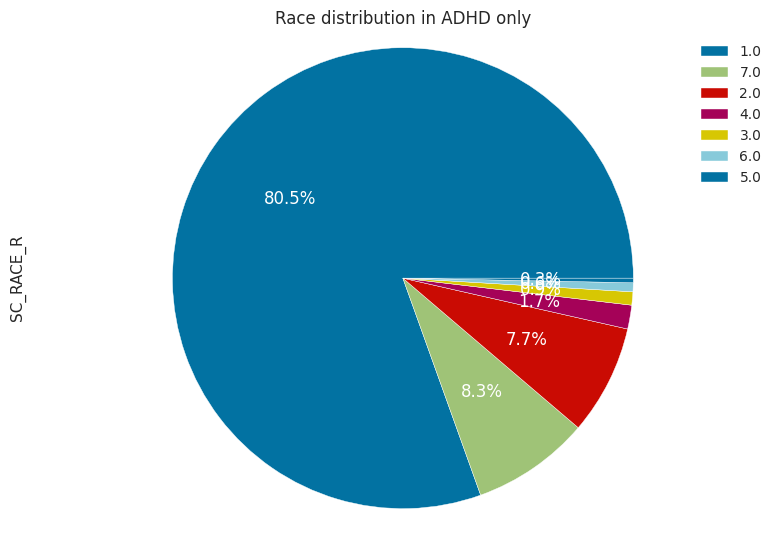

In [ ]:
plt.figure(0)
up1[(up1['K2Q35A']==1) & (up1['K2Q31A']==2)]['SC_RACE_R'].value_counts().plot(kind='pie', autopct='%.1f%%',textprops={'color':"w"})
plt.legend(loc='upper right')
plt.axis('equal')
plt.title('Race distribution in ASD only')

plt.figure(1)
up1[(up1['K2Q35A']==2) & (up1['K2Q31A']==1)]['SC_RACE_R'].value_counts().plot(kind='pie', autopct='%.1f%%',textprops={'color':"w"})
plt.legend(loc='upper right')
plt.axis('equal')
plt.title('Race distribution in ADHD only')
plt.tight_layout()
plt.show()

In [ ]:
up1['SC_RACE_R'].value_counts()/up1.shape[0]

1.0    0.771254
7.0    0.082044
2.0    0.067072
4.0    0.055872
6.0    0.009444
3.0    0.008945
5.0    0.005369
Name: SC_RACE_R, dtype: float64

In [ ]:
## race demographics

race_cat = ['White alone','Black or African American alone','American Indian or Alaska Native alone','Asian alone',
            'Native Hawaiian and Other Pacific Islander alone','Some Other Race alone','Two or More Races']

for i in range(1,8):
  print(f"Race: {race_cat[i-1]} - ASD only: {up1[(up1['K2Q35A']==1) & (up1['K2Q31A']==2) & (up1['SC_RACE_R']==i)].shape[0]}")
  print(f"Race: {race_cat[i-1]} - ADHD only: {up1[(up1['K2Q35A']==2) & (up1['K2Q31A']==1) & (up1['SC_RACE_R']==i)].shape[0]}")
  print(f"Race: {race_cat[i-1]} - ASD and ADHD: {up1[(up1['K2Q35A']==1) & (up1['K2Q31A']==1) & (up1['SC_RACE_R']==i)].shape[0]}")
  print("\n")

Race: White alone - ASD only: 3167
Race: White alone - ADHD only: 18400
Race: White alone - ASD and ADHD: 2995


Race: Black or African American alone - ASD only: 370
Race: Black or African American alone - ADHD only: 1759
Race: Black or African American alone - ASD and ADHD: 264


Race: American Indian or Alaska Native alone - ASD only: 43
Race: American Indian or Alaska Native alone - ADHD only: 212
Race: American Indian or Alaska Native alone - ASD and ADHD: 33


Race: Asian alone - ASD only: 239
Race: Asian alone - ADHD only: 382
Race: Asian alone - ASD and ADHD: 123


Race: Native Hawaiian and Other Pacific Islander alone - ASD only: 22
Race: Native Hawaiian and Other Pacific Islander alone - ADHD only: 73
Race: Native Hawaiian and Other Pacific Islander alone - ASD and ADHD: 19


Race: Some Other Race alone - ASD only: 44
Race: Some Other Race alone - ADHD only: 143
Race: Some Other Race alone - ASD and ADHD: 18


Race: Two or More Races - ASD only: 430
Race: Two or More Races - 

In [ ]:
diag_df = up1.copy()

diag_df['Learning_disability'] = np.where(diag_df["K2Q30A"] == 1.0, 1.0, 0.0)
diag_df['ADHD'] = np.where(diag_df["K2Q31A"] == 1.0, 1.0, 0.0)
diag_df['Depression'] = np.where(diag_df["K2Q32A"] == 1.0, 1.0, 0.0)
diag_df['Anxiety'] = np.where(diag_df["K2Q33A"] == 1.0, 1.0, 0.0)
diag_df['Behavioral_problems'] = np.where(diag_df["K2Q34A"] == 1.0, 1.0, 0.0)
diag_df['ASD'] = np.where(diag_df["K2Q35A"] == 1.0, 1.0, 0.0)
diag_df['Developmental_delay'] = np.where(diag_df["K2Q36A"] == 1.0, 1.0, 0.0)
diag_df['Speech_disorder'] = np.where(diag_df["K2Q37A"] == 1.0, 1.0, 0.0)
diag_df['Tourette_syndrome'] = np.where(diag_df["K2Q38A"] == 1.0, 1.0, 0.0)
diag_df['Intellectual_disability'] = np.where(diag_df["K2Q60A"] == 1.0, 1.0, 0.0)

In [ ]:
## studying number of children with different disorders

classes = list(diag_df.columns.values)[-10:]
label_counts = diag_df.iloc[:,-10:].sum().values

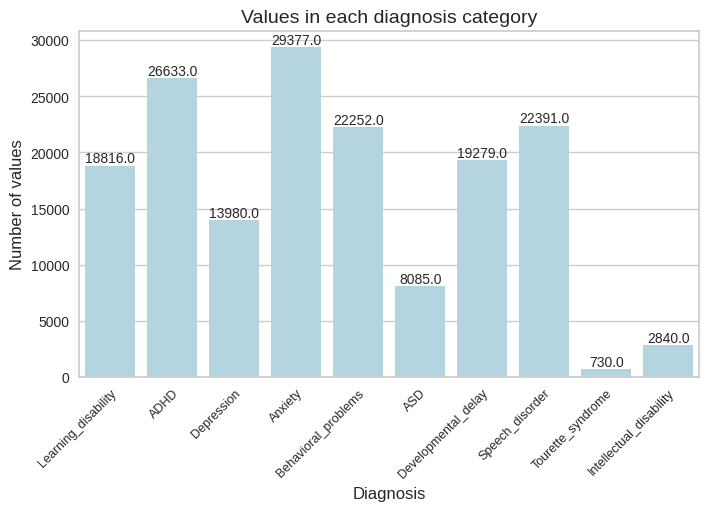

In [ ]:
plt.figure(figsize=(8,4.5))
ax = sns.barplot(x = classes, y = label_counts, color='lightblue')
plt.title("Values in each diagnosis category", fontsize=14)
plt.ylabel('Number of values', fontsize=12)
plt.xlabel('Diagnosis', fontsize=12)
#plt.xticks(rotation=45)
#ax.set(xticks=np.arange(len(classes)), xticklabels=classes)
#ax.set_xticklabels(len(classes), rotation=45)
ax.set_xticks(np.arange(len(classes)), classes, rotation=45, ha='right', rotation_mode='anchor', fontsize=9)

#adding the text labels
rects = ax.patches
for rect, label in zip(rects, label_counts):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=10)
plt.show()

In [ ]:
diag_df[diag_df['ASD']==1]['ASD'].sum()

8085.0

In [ ]:
comb = {}
dis1 = ['ASD', 'ADHD']
dis2 = list(set(classes) - set(dis1))
for i in dis1:
  for j in dis2:
    #comb[f'{i}+{j}'] = diag_df[diag_df[i]==1][i].sum() + diag_df[diag_df[j]==1][j].sum()
    #comb[f'{i}+{j}'] = diag_df[(diag_df[i]==1) & (diag_df[diag_df[j]==1])].shape[0]
    print(f'{i}+{j}')

#comb['ASD+ADHD'] = diag_df[(diag_df['ASD']==1) & (diag_df[diag_df['ADHD']==1])].shape[0]

ASD+Learning_disability
ASD+Tourette_syndrome
ASD+Developmental_delay
ASD+Speech_disorder
ASD+Anxiety
ASD+Intellectual_disability
ASD+Depression
ASD+Behavioral_problems
ADHD+Learning_disability
ADHD+Tourette_syndrome
ADHD+Developmental_delay
ADHD+Speech_disorder
ADHD+Anxiety
ADHD+Intellectual_disability
ADHD+Depression
ADHD+Behavioral_problems


In [ ]:
print(diag_df[(diag_df['ASD']==1) & (diag_df['Learning_disability']==1)].shape[0])
print(diag_df[(diag_df['ASD']==1) & (diag_df['Tourette_syndrome']==1)].shape[0])
print(diag_df[(diag_df['ASD']==1) & (diag_df['Developmental_delay']==1)].shape[0])
print(diag_df[(diag_df['ASD']==1) & (diag_df['Speech_disorder']==1)].shape[0])
print(diag_df[(diag_df['ASD']==1) & (diag_df['Anxiety']==1)].shape[0])
print(diag_df[(diag_df['ASD']==1) & (diag_df['Intellectual_disability']==1)].shape[0])
print(diag_df[(diag_df['ASD']==1) & (diag_df['Depression']==1)].shape[0])
print(diag_df[(diag_df['ASD']==1) & (diag_df['Behavioral_problems']==1)].shape[0])

print(diag_df[(diag_df['ADHD']==1) & (diag_df['Learning_disability']==1)].shape[0])
print(diag_df[(diag_df['ADHD']==1) & (diag_df['Tourette_syndrome']==1)].shape[0])
print(diag_df[(diag_df['ADHD']==1) & (diag_df['Developmental_delay']==1)].shape[0])
print(diag_df[(diag_df['ADHD']==1) & (diag_df['Speech_disorder']==1)].shape[0])
print(diag_df[(diag_df['ADHD']==1) & (diag_df['Anxiety']==1)].shape[0])
print(diag_df[(diag_df['ADHD']==1) & (diag_df['Intellectual_disability']==1)].shape[0])
print(diag_df[(diag_df['ADHD']==1) & (diag_df['Depression']==1)].shape[0])
print(diag_df[(diag_df['ADHD']==1) & (diag_df['Behavioral_problems']==1)].shape[0])

print(diag_df[(diag_df['ASD']==1) & (diag_df['ADHD']==1)].shape[0])

4525
156
5522
4467
3797
1271
1540
4688
9720
395
6833
5238
11316
1145
5977
13309
3770


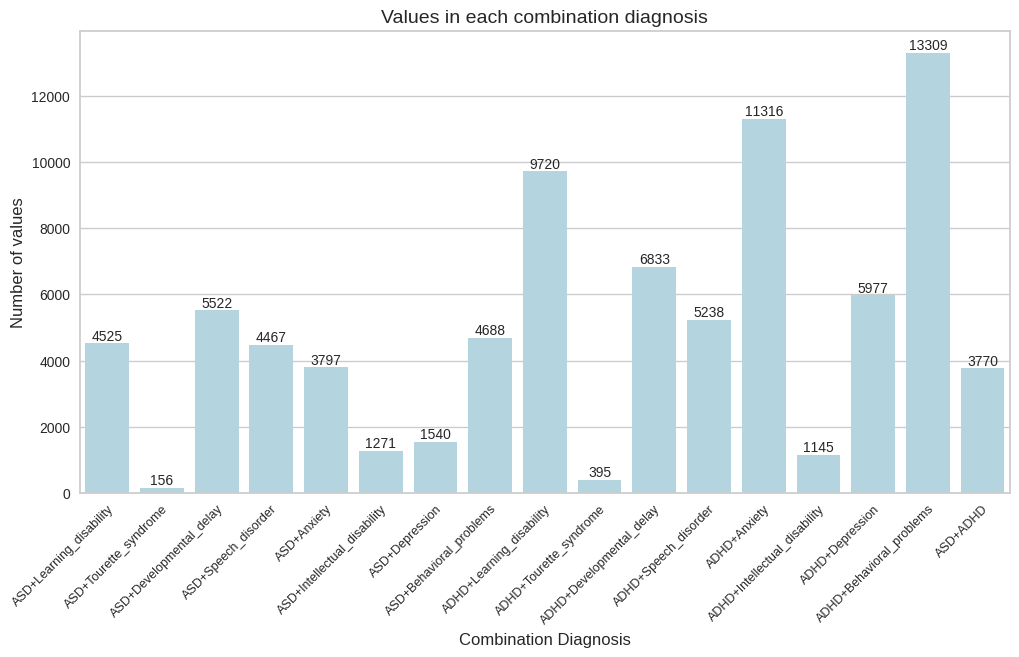

In [ ]:
comb_classes = ['ASD+Learning_disability', 'ASD+Tourette_syndrome', 'ASD+Developmental_delay', 'ASD+Speech_disorder', 'ASD+Anxiety', 'ASD+Intellectual_disability',
                'ASD+Depression', 'ASD+Behavioral_problems', 'ADHD+Learning_disability', 'ADHD+Tourette_syndrome', 'ADHD+Developmental_delay', 'ADHD+Speech_disorder',
                'ADHD+Anxiety', 'ADHD+Intellectual_disability', 'ADHD+Depression', 'ADHD+Behavioral_problems','ASD+ADHD']
comb_values = [4525, 156, 5522, 4467, 3797, 1271, 1540, 4688, 9720, 395, 6833, 5238, 11316, 1145, 5977, 13309, 3770]

plt.figure(figsize=(12,6))
ax = sns.barplot(x = comb_classes, y = comb_values, color='lightblue')
plt.title("Values in each combination diagnosis", fontsize=14)
plt.ylabel('Number of values', fontsize=12)
plt.xlabel('Combination Diagnosis', fontsize=12)

ax.set_xticks(np.arange(len(comb_classes)), comb_classes, rotation=45, ha='right', rotation_mode='anchor', fontsize=9)

#adding the text labels
rects = ax.patches
for rect, label in zip(rects, comb_values):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=10)
plt.show()

## ML for different classifications from feature set 1

In [12]:
## using decision tree and logistic regression models

dt_model = DecisionTreeClassifier(max_depth=5)

lr_model = LogisticRegression()

### Any developmental delay vs none




In [13]:
updated_df1.head()

SC_AGE_YEARS  SC_SEX  K2Q30A  K2Q31A  K2Q32A  K2Q33A  K2Q34A  K2Q35A  \
1          11.0     1.0     2.0     2.0     2.0     2.0     2.0     2.0   
2          10.0     2.0     2.0     2.0     2.0     1.0     2.0     2.0   
4          11.0     1.0     2.0     2.0     2.0     2.0     2.0     2.0   
6          17.0     2.0     2.0     2.0     2.0     2.0     2.0     2.0   
8          15.0     2.0     2.0     2.0     2.0     2.0     2.0     2.0   

   K2Q36A  K2Q37A  K2Q38A  K2Q60A  MEMORYCOND  WALKSTAIRS  K6Q71_R  K7Q84_R  \
1     2.0     2.0     2.0     2.0         2.0         2.0      2.0      2.0   
2     2.0     2.0     2.0     2.0         2.0         2.0      1.0      1.0   
4     2.0     2.0     2.0     2.0         2.0         2.0      1.0      2.0   
6     2.0     2.0     2.0     2.0         2.0         2.0      1.0      1.0   
8     2.0     2.0     2.0     2.0         2.0         2.0      1.0      1.0   

   K7Q85_R  K7Q70_R  MAKEFRIEND  
1      2.0      3.0         1.0  
2      1.0      3.0         1.0  
4      2.0      3.0         1.0  
6      1.0      3.0         1.0  
8      1.0      3.0         1.0

In [14]:
dev1 = updated_df1[(updated_df1['K2Q30A'] == 1) | (updated_df1['K2Q31A'] == 1) | (updated_df1['K2Q32A'] == 1) | (updated_df1['K2Q33A'] == 1) |
                   (updated_df1['K2Q34A'] == 1) | (updated_df1['K2Q35A'] == 1) | (updated_df1['K2Q36A'] == 1) | (updated_df1['K2Q37A'] == 1) |
                   (updated_df1['K2Q38A'] == 1) | (updated_df1['K2Q60A'] == 1)]
dev1['is_any_disab'] = 1

no_dev1 = updated_df1[(updated_df1['K2Q30A'] == 2) & (updated_df1['K2Q31A'] == 2) & (updated_df1['K2Q32A'] == 2) & (updated_df1['K2Q33A'] == 2) &
                      (updated_df1['K2Q34A'] == 2) & (updated_df1['K2Q35A'] == 2) & (updated_df1['K2Q36A'] == 2) & (updated_df1['K2Q37A'] == 2) &
                      (updated_df1['K2Q38A'] == 2) & (updated_df1['K2Q60A'] == 2)]
no_dev1['is_any_disab'] = 0


print(dev1.shape, no_dev1.shape)

(58469, 20) (118887, 20)


<ipython-input-14-9c30b493abf8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dev1['is_any_disab'] = 1
<ipython-input-14-9c30b493abf8>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_dev1['is_any_disab'] = 0


In [ ]:
all_del1 = pd.concat([dev1, no_dev1.sample(dev1.shape[0], random_state=1)])
all_del1 = all_del1.sample(frac=1)
all_del1.reset_index(drop=True, inplace=True)

In [ ]:
all_del1[['SC_AGE_YEARS', 'SC_SEX', 'MEMORYCOND', 'WALKSTAIRS', 'K6Q71_R', 'K7Q84_R', 'K7Q85_R',
          'K7Q70_R', 'MAKEFRIEND']].corr().style.background_gradient(cmap='coolwarm')

In [ ]:
any_delay_X1 = all_del1[['SC_AGE_YEARS', 'SC_SEX', 'MEMORYCOND', 'WALKSTAIRS', 'K6Q71_R', 'K7Q84_R', 'K7Q85_R', 'K7Q70_R', 'MAKEFRIEND']]
any_delay_Y1 = all_del1['is_any_disab']

In [ ]:
any_del_X_tr1, any_del_X_test1, any_del_Y_tr1, any_del_Y_test1 = train_test_split(any_delay_X1, any_delay_Y1, random_state=42, test_size=0.10, shuffle=True)
any_del_xtr1, any_del_xval1, any_del_ytr1, any_del_yval1 = train_test_split(any_del_X_tr1, any_del_Y_tr1, random_state=42, test_size=0.10, shuffle=True)

In [ ]:
dt_model.fit(any_del_xtr1, any_del_ytr1)

any_del_ypred1 = dt_model.predict(any_del_xval1)

In [ ]:
print("Accuracy = ", accuracy_score(any_del_yval1, any_del_ypred1))
print("Precision score: ", precision_score(any_del_yval1, any_del_ypred1))
print("Recall (sensitivity)): ", recall_score(any_del_yval1, any_del_ypred1))
print("Specificity: ", recall_score(any_del_yval1, any_del_ypred1, pos_label=0))

print("F1-score: ", f1_score(any_del_yval1, any_del_ypred1))
print(f"ROC AUC: {roc_auc_score(any_del_yval1, any_del_ypred1)}\n")
print(classification_report(any_del_yval1, any_del_ypred1))

Accuracy =  0.7324465558194775
Precision score:  0.7996113675006072
Recall (sensitivity)):  0.6231307968957032
Specificity:  0.8426173216329645
F1-score:  0.7004255319148937
ROC AUC: 0.7328740592643339

              precision    recall  f1-score   support

           0       0.69      0.84      0.76      5242
           1       0.80      0.62      0.70      5283

    accuracy                           0.73     10525
   macro avg       0.74      0.73      0.73     10525
weighted avg       0.74      0.73      0.73     10525



In [ ]:
lr_model.fit(any_del_xtr1, any_del_ytr1)

ypr1 = lr_model.predict(any_del_xval1)

In [ ]:
print("Accuracy = ", accuracy_score(any_del_yval1, ypr1))
print("Precision score: ", precision_score(any_del_yval1, ypr1))
print("Recall (sensitivity)): ", recall_score(any_del_yval1, ypr1))
print("Specificity: ", recall_score(any_del_yval1, ypr1, pos_label=0))

print("F1-score: ", f1_score(any_del_yval1, ypr1))
print(f"ROC AUC: {roc_auc_score(any_del_yval1, ypr1)}\n")
print(classification_report(any_del_yval1, ypr1))

Accuracy =  0.7371021377672209
Precision score:  0.7984626471294739
Recall (sensitivity)):  0.6329017517136329
Specificity:  0.8408875402996396
F1-score:  0.7061072756240043
ROC AUC: 0.7368946460066363

              precision    recall  f1-score   support

           0       0.70      0.84      0.76      5273
           1       0.80      0.63      0.71      5252

    accuracy                           0.74     10525
   macro avg       0.75      0.74      0.73     10525
weighted avg       0.75      0.74      0.73     10525



In [ ]:
test1 = lr_model.predict(any_del_X_test1)       ## predicting on test set

print("Accuracy = ", accuracy_score(any_del_Y_test1, test1))
print("Precision score: ", precision_score(any_del_Y_test1, test1))
print("Recall (sensitivity)): ", recall_score(any_del_Y_test1, test1))
print("Specificity: ", recall_score(any_del_Y_test1, test1, pos_label=0))

print("F1-score: ", f1_score(any_del_Y_test1, test1))
print(f"ROC AUC: {roc_auc_score(any_del_Y_test1, test1)}\n")
print(classification_report(any_del_Y_test1, test1))

Accuracy =  0.7278091328886609
Precision score:  0.8029755579171095
Recall (sensitivity)):  0.6261186609214452
Specificity:  0.8362190812720848
F1-score:  0.7036036874941802
ROC AUC: 0.731168871096765

              precision    recall  f1-score   support

           0       0.68      0.84      0.75      5660
           1       0.80      0.63      0.70      6034

    accuracy                           0.73     11694
   macro avg       0.74      0.73      0.73     11694
weighted avg       0.74      0.73      0.73     11694



### ASD or ADHD vs None

In [12]:
## testing ASD or ADHD vs none

is_asd_adhd1 = updated_df1[(updated_df1['K2Q35A']==1) | (updated_df1['K2Q31A']==1)]
is_asd_adhd1['target']=1

is_none1 = updated_df1[(updated_df1['K2Q30A'] == 2) & (updated_df1['K2Q31A'] == 2) & (updated_df1['K2Q32A'] == 2) & (updated_df1['K2Q33A'] == 2) &
                      (updated_df1['K2Q34A'] == 2) & (updated_df1['K2Q35A'] == 2) & (updated_df1['K2Q36A'] == 2) & (updated_df1['K2Q37A'] == 2) &
                      (updated_df1['K2Q38A'] == 2) & (updated_df1['K2Q60A'] == 2)]
is_none1['target']=0

<ipython-input-12-66626f11f87f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  is_asd_adhd1['target']=1
<ipython-input-12-66626f11f87f>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  is_none1['target']=0


In [ ]:
binclf1 = pd.concat([is_asd_adhd1, is_none1.sample(is_asd_adhd1.shape[0], random_state=2)])
binclf1 = binclf1.sample(frac=1)

In [ ]:
binclf1.shape

(55686, 20)

In [ ]:
binclf1.columns.values

array(['SC_AGE_YEARS', 'SC_SEX', 'K2Q30A', 'K2Q31A', 'K2Q32A', 'K2Q33A',
       'K2Q34A', 'K2Q35A', 'K2Q36A', 'K2Q37A', 'K2Q38A', 'K2Q60A',
       'MEMORYCOND', 'WALKSTAIRS', 'K6Q71_R', 'K7Q84_R', 'K7Q85_R',
       'K7Q70_R', 'MAKEFRIEND', 'target'], dtype=object)

In [ ]:
fX1 = binclf1[['SC_AGE_YEARS', 'SC_SEX', 'MEMORYCOND', 'WALKSTAIRS', 'K6Q71_R', 'K7Q84_R', 'K7Q85_R', 'K7Q70_R', 'MAKEFRIEND']]
fY1 = binclf1['target']

fX_tr1, fX_test1, fY_tr1, fY_test1 = train_test_split(fX1, fY1, random_state=42, test_size=0.10, shuffle=True)
fx_train1, fx_val1, fy_train1, fy_val1 = train_test_split(fX_tr1, fY_tr1, random_state=20, test_size=0.10, shuffle=True)

In [ ]:
dt_model.fit(fx_train1, fy_train1)

asd_adhd_pred1 = dt_model.predict(fx_val1)

In [ ]:
print("Accuracy = ", accuracy_score(fy_val1, asd_adhd_pred1))
print("Precision score: ", precision_score(fy_val1, asd_adhd_pred1))
print("Recall (sensitivity)): ", recall_score(fy_val1, asd_adhd_pred1))
print("Specificity: ", recall_score(fy_val1, asd_adhd_pred1, pos_label=0))

print("F1-score: ", f1_score(fy_val1, asd_adhd_pred1))
print(f"ROC AUC: {roc_auc_score(fy_val1, asd_adhd_pred1)}\n")
print(classification_report(fy_val1, asd_adhd_pred1))

Accuracy =  0.8054668794892259
Precision score:  0.8574126534466477
Recall (sensitivity)):  0.7296102852551225
Specificity:  0.8803012286959968
F1-score:  0.7883655307141306
ROC AUC: 0.8049557569755597

              precision    recall  f1-score   support

           0       0.77      0.88      0.82      2523
           1       0.86      0.73      0.79      2489

    accuracy                           0.81      5012
   macro avg       0.81      0.80      0.80      5012
weighted avg       0.81      0.81      0.80      5012



<Axes: ylabel='None'>

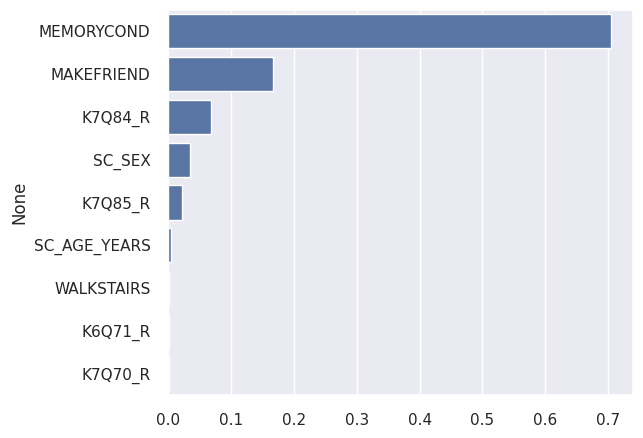

In [ ]:
feat_imp1 = dt_model.feature_importances_

sorted_ind1 = feat_imp1.argsort()[::-1]
sorted_feat_names1 = fx_train1.columns[sorted_ind1]
sorted_imp1 = feat_imp1[sorted_ind1]

sns.set(rc={'figure.figsize':(6,5)})
sns.barplot(x=sorted_imp1, y=sorted_feat_names1)

In [ ]:
lr_model.fit(fx_train1, fy_train1)

asd_adhd_logpred1 = lr_model.predict(fx_val1)

In [ ]:
print("Accuracy = ", accuracy_score(fy_val1, asd_adhd_logpred1))
print("Precision score: ", precision_score(fy_val1, asd_adhd_logpred1))
print("Recall (sensitivity)): ", recall_score(fy_val1, asd_adhd_logpred1))
print("Specificity: ", recall_score(fy_val1, asd_adhd_logpred1, pos_label=0))

print("F1-score: ", f1_score(fy_val1, asd_adhd_logpred1))
print(f"ROC AUC: {roc_auc_score(fy_val1, asd_adhd_logpred1)}\n")
print(classification_report(fy_val1, asd_adhd_logpred1))

Accuracy =  0.8150438946528332
Precision score:  0.8656438865643886
Recall (sensitivity)):  0.7448
Specificity:  0.884952229299363
F1-score:  0.8006880240808428
ROC AUC: 0.8148761146496816

              precision    recall  f1-score   support

           0       0.78      0.88      0.83      2512
           1       0.87      0.74      0.80      2500

    accuracy                           0.82      5012
   macro avg       0.82      0.81      0.81      5012
weighted avg       0.82      0.82      0.81      5012



<Axes: ylabel='Feature'>

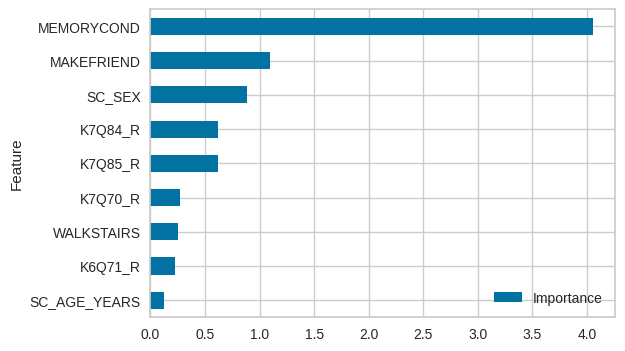

In [ ]:
log_coef = lr_model.coef_[0]

log_feature_importance = pd.DataFrame({'Feature': fx_val1.columns, 'Importance': np.abs(log_coef)})
log_feature_importance = log_feature_importance.sort_values('Importance', ascending=True)
log_feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(6, 4))

In [ ]:
fftest1 = lr_model.predict(fX_test1)       ## predicting on test set

print("Accuracy = ", accuracy_score(fY_test1, fftest1))
print("Precision score: ", precision_score(fY_test1, fftest1))
print("Recall (sensitivity)): ", recall_score(fY_test1, fftest1))
print("Specificity: ", recall_score(fY_test1, fftest1, pos_label=0))

print("F1-score: ", f1_score(fY_test1, fftest1))
print(f"ROC AUC: {roc_auc_score(fY_test1, fftest1)}\n")
print(classification_report(fY_test1, fftest1))

Accuracy =  0.816843239360747
Precision score:  0.8745247148288974
Recall (sensitivity)):  0.7411385606874329
Specificity:  0.8930115273775217
F1-score:  0.8023255813953488
ROC AUC: 0.8170750440324772

              precision    recall  f1-score   support

           0       0.77      0.89      0.83      2776
           1       0.87      0.74      0.80      2793

    accuracy                           0.82      5569
   macro avg       0.82      0.82      0.82      5569
weighted avg       0.82      0.82      0.82      5569



### Multilabel ASD/ADHD classification

In [13]:
mullab1 = updated_df1.copy()
mullab1['ASD'] = np.where(mullab1['K2Q35A']==1, 1, 0)
mullab1['ADHD'] = np.where(mullab1['K2Q31A']==1, 1, 0)

In [ ]:
print(mullab1['ASD'].value_counts(), mullab1['ADHD'].value_counts())

ASD
0    170916
1      6440
Name: count, dtype: int64 ADHD
0    152532
1     24824
Name: count, dtype: int64


In [ ]:
mullab1[(mullab1['ASD']==1) & (mullab1['ADHD']==1)].shape[0]

3421

In [14]:
both = mullab1[(mullab1['ASD']==1) & (mullab1['ADHD']==1)]
asd = mullab1[(mullab1['ASD']==1) & (~mullab1.index.isin(both.index))]
adhd = mullab1[(mullab1['ADHD']==1) & (~mullab1.index.isin(both.index)) & (~mullab1.index.isin(asd.index))]

none = is_none1.sample((2*asd.shape[0]+both.shape[0]), random_state=4)
none['ASD']=0
none['ADHD']=0
none = none.drop('target', axis=1)

print(both.shape, asd.shape, adhd.shape, none.shape)

(3421, 21) (3019, 21) (21403, 21) (9459, 21)


In [ ]:
#none.columns == asd.columns

In [15]:
muldf1 = pd.concat([both, asd, adhd.sample(asd.shape[0], random_state=2), none])
muldf1 = muldf1.sample(frac=1)
muldf1.shape

(18918, 21)

In [ ]:
muldf1

SC_AGE_YEARS  SC_SEX  K2Q30A  K2Q31A  K2Q32A  K2Q33A  K2Q34A  K2Q35A  \
1993            14.0     1.0     2.0     2.0     2.0     2.0     2.0     1.0   
131590          13.0     1.0     2.0     2.0     2.0     2.0     2.0     2.0   
87058           11.0     2.0     2.0     2.0     2.0     2.0     2.0     2.0   
16660           17.0     2.0     2.0     2.0     2.0     2.0     2.0     2.0   
206430          15.0     1.0     2.0     2.0     2.0     2.0     2.0     2.0   
...              ...     ...     ...     ...     ...     ...     ...     ...   
194594          11.0     2.0     2.0     2.0     2.0     2.0     2.0     2.0   
236814          17.0     1.0     2.0     1.0     2.0     2.0     2.0     1.0   
265488          12.0     1.0     2.0     2.0     2.0     2.0     2.0     2.0   
65618           17.0     1.0     2.0     2.0     2.0     2.0     2.0     1.0   
22149           10.0     2.0     2.0     1.0     2.0     2.0     2.0     2.0   

        K2Q36A  K2Q37A  ...  K2Q60A  MEMORYCOND  WALKSTAIRS  K6Q71_R  K7Q84_R  \
1993       2.0     2.0  ...     2.0         1.0         2.0      2.0      3.0   
131590     2.0     2.0  ...     2.0         2.0         2.0      2.0      2.0   
87058      2.0     2.0  ...     2.0         2.0         2.0      1.0      1.0   
16660      2.0     2.0  ...     2.0         2.0         2.0      1.0      1.0   
206430     2.0     2.0  ...     2.0         2.0         2.0      1.0      1.0   
...        ...     ...  ...     ...         ...         ...      ...      ...   
194594     2.0     2.0  ...     2.0         2.0         2.0      1.0      1.0   
236814     2.0     2.0  ...     2.0         2.0         2.0      1.0      1.0   
265488     2.0     2.0  ...     2.0         2.0         2.0      2.0      2.0   
65618      1.0     2.0  ...     2.0         2.0         2.0      1.0      2.0   
22149      2.0     2.0  ...     2.0         1.0         2.0      1.0      2.0   

        K7Q85_R  K7Q70_R  MAKEFRIEND  ASD  ADHD  
1993        2.0      3.0         3.0    1     0  
131590      2.0      3.0         1.0    0     0  
87058       2.0      4.0         3.0    0     0  
16660       2.0      3.0         1.0    0     0  
206430      1.0      2.0         1.0    0     0  
...         ...      ...         ...  ...   ...  
194594      1.0      4.0         2.0    0     0  
236814      2.0      4.0         2.0    1     1  
265488      1.0      4.0         2.0    0     0  
65618       2.0      4.0         2.0    1     0  
22149       3.0      2.0         1.0    0     1  

[18918 rows x 21 columns]

In [16]:
mulX1 = muldf1[['SC_AGE_YEARS', 'SC_SEX', 'MEMORYCOND', 'WALKSTAIRS', 'K6Q71_R', 'K7Q84_R', 'K7Q85_R', 'K7Q70_R', 'MAKEFRIEND']]
mulY1 = muldf1[['ASD', 'ADHD']].values

In [17]:
mulX_tr1, mulX_test1, mulY_tr1, mulY_test1 = train_test_split(mulX1, mulY1, random_state=42, test_size=0.10, shuffle=True)
mulx_train1, mulx_val1, muly_train1, muly_val1 = train_test_split(mulX_tr1, mulY_tr1, random_state=20, test_size=0.10, shuffle=True)

In [ ]:
### using multi output classifier first

clf1 = MultiOutputClassifier(LogisticRegression(max_iter=500,random_state=42))
clf1.fit(mulx_train1, muly_train1)

MultiOutputClassifier(estimator=LogisticRegression(max_iter=500,
                                                   random_state=42))

# Just testing specifically for features for multi label

In [18]:
clf_ee = MultiOutputClassifier(RandomForestClassifier())
clf_ee.fit(mulx_train1, muly_train1)

MultiOutputClassifier(estimator=RandomForestClassifier())

In [19]:
feat_impts = []
for c in clf_ee.estimators_:
    feat_impts.append(c.feature_importances_)

np.mean(feat_impts, axis=0)

array([0.20042072, 0.03487904, 0.19922722, 0.0073784 , 0.06273441,
       0.08090078, 0.08984421, 0.07521171, 0.24940351])

In [20]:
mulx_train1.columns

Index(['SC_AGE_YEARS', 'SC_SEX', 'MEMORYCOND', 'WALKSTAIRS', 'K6Q71_R',
       'K7Q84_R', 'K7Q85_R', 'K7Q70_R', 'MAKEFRIEND'],
      dtype='object')

In [21]:
for idx, model in enumerate(clf_ee.estimators_):
    print(f"Feature importances for label {idx}:")
    print(model.feature_importances_)

Feature importances for label 0:
[0.16749878 0.03533858 0.16760199 0.00559787 0.05034596 0.06315327
 0.07926052 0.06065208 0.37055094]
Feature importances for label 1:
[0.23334265 0.0344195  0.23085246 0.00915893 0.07512285 0.09864829
 0.1004279  0.08977133 0.12825609]


In [22]:
importances = clf_ee.estimators_[0].feature_importances_  # For the first label (ASD)
feature_names = mulX_test1.columns

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("Feature Importances for ASD:\n", importance_df)

Feature Importances for ASD:
         Feature  Importance
8    MAKEFRIEND    0.370551
2    MEMORYCOND    0.167602
0  SC_AGE_YEARS    0.167499
6       K7Q85_R    0.079261
5       K7Q84_R    0.063153
7       K7Q70_R    0.060652
4       K6Q71_R    0.050346
1        SC_SEX    0.035339
3    WALKSTAIRS    0.005598


In [23]:
importances = clf_ee.estimators_[1].feature_importances_  # For the first label (ADHD)
feature_names = mulX_test1.columns

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("Feature Importances for ADHD:\n", importance_df)

Feature Importances for ADHD:
         Feature  Importance
0  SC_AGE_YEARS    0.233343
2    MEMORYCOND    0.230852
8    MAKEFRIEND    0.128256
6       K7Q85_R    0.100428
5       K7Q84_R    0.098648
7       K7Q70_R    0.089771
4       K6Q71_R    0.075123
1        SC_SEX    0.034419
3    WALKSTAIRS    0.009159


In [24]:
# Generating predictions and predicted probabilities
y_pred_ee = clf_ee.predict(mulX_test1)
y_pred_proba_ee = clf_ee.predict_proba(mulX_test1)  # Get predicted probabilities

In [25]:
print(confusion_matrix(mulY_test1.argmax(axis=1), y_pred_ee.argmax(axis=1)))

[[1429  130]
 [ 256   77]]


In [26]:
y_pred_ee

array([[1, 0],
       [0, 0],
       [0, 0],
       ...,
       [0, 0],
       [0, 0],
       [0, 0]])

In [27]:
mulY_test1

array([[0, 0],
       [1, 0],
       [0, 0],
       ...,
       [1, 1],
       [0, 1],
       [0, 0]])

In [28]:
columns = [f"label_{i}" for i in range(y_pred_ee.shape[1])]

# Convert predictions and actual values to DataFrames for easier manipulation
y_pred_ee_df = pd.DataFrame(y_pred_ee, columns=columns, index=mulX_test1.index)
y_true_ee_df = pd.DataFrame(mulY_test1, columns=columns, index=mulX_test1.index)

# Find incorrect predictions (False Positives or True Negatives)
incorrect_predictions = (y_pred_ee_df != y_true_ee_df)

incorrect_data = mulX_test1[incorrect_predictions.any(axis=1)]

In [29]:
# Flatten the DataFrame to identify false positives and true negatives
false_positives = (y_true_ee_df == 0) & (y_pred_ee_df == 1)
true_negatives = (y_true_ee_df == 0) & (y_pred_ee_df == 0)

# Display the counts of false positives and true negatives for each label
false_positives_count = false_positives.sum()
true_negatives_count = true_negatives.sum()

print("False Positives Count:\n", false_positives_count)
print("True Negatives Count:\n", true_negatives_count)

False Positives Count:
 label_0    162
label_1    192
dtype: int64
True Negatives Count:
 label_0    1087
label_1    1029
dtype: int64


In [ ]:
### incorrect_predictions = (mulY_test1.argmax(axis=1) != y_pred_ee.argmax(axis=1))

In [30]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 10.0 MB/s eta 0:00:00


In [55]:
mulY_test1[i]

array([1, 1])

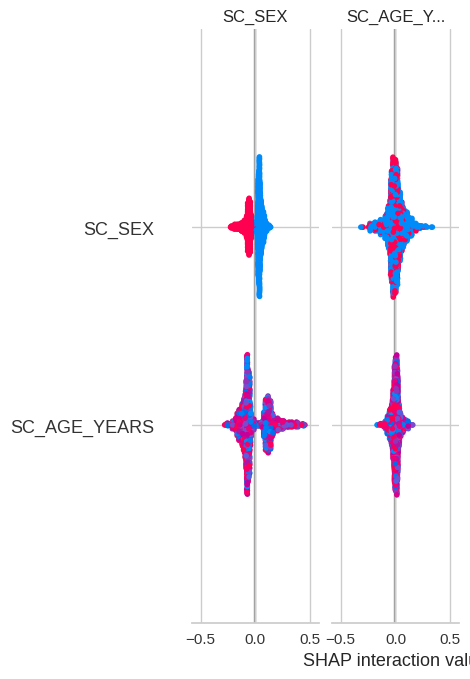

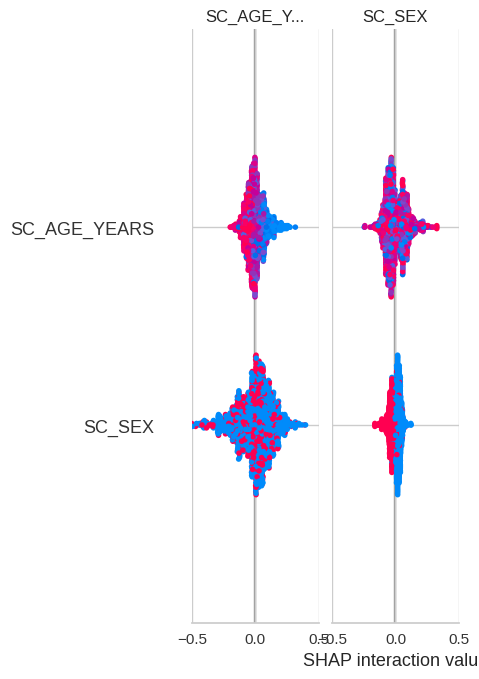

In [31]:
import shap

# Initialize SHAP explainer for the first label (ASD)
explainer_asd = shap.TreeExplainer(clf_ee.estimators_[0])  # Estimator for ASD
shap_values_asd = explainer_asd.shap_values(mulX_test1)

#### second label (ADHD)
explainer_adhd = shap.TreeExplainer(clf_ee.estimators_[1])  # Estimator for ADHD
shap_values_adhd = explainer_adhd.shap_values(mulX_test1)

# Plot SHAP values
shap.summary_plot(shap_values_asd, mulX_test1, feature_names=mulX1.columns)

shap.summary_plot(shap_values_adhd, mulX_test1, feature_names=mulX1.columns)

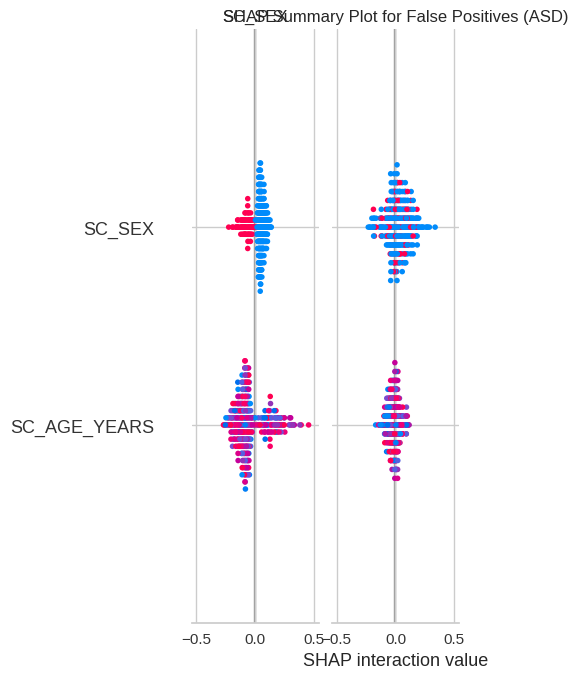

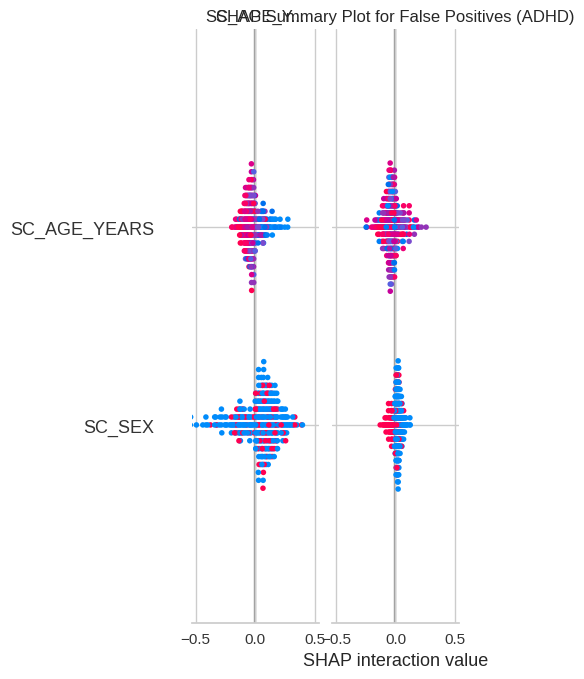

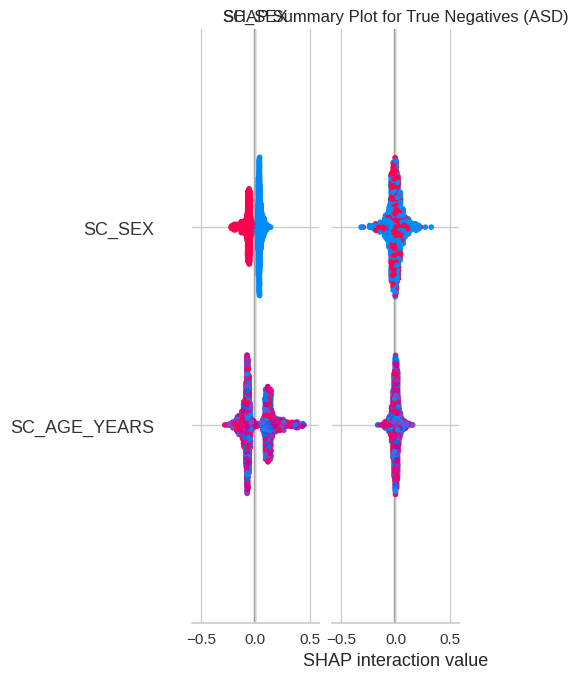

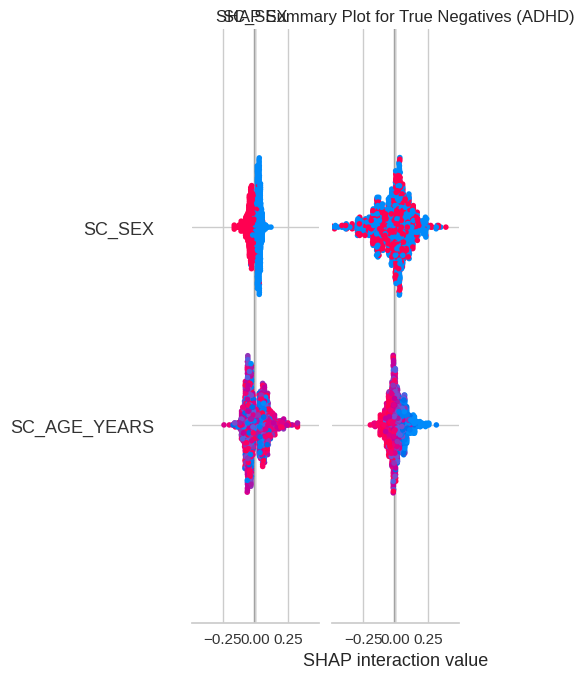

In [32]:
# Extract SHAP values for false positives
false_positives_indices = false_positives.any(axis=1)
shap_values_fp_asd = shap_values_asd[false_positives_indices]
mulx_fp_asd = mulX_test1[false_positives_indices]

shap_values_fp_adhd = shap_values_adhd[false_positives_indices]
mulx_fp_adhd = mulX_test1[false_positives_indices]

# Summary plot for false positives (ASD)
shap.summary_plot(shap_values_fp_asd, mulx_fp_asd, feature_names=mulX_test1.columns, show=False)
plt.title('SHAP Summary Plot for False Positives (ASD)')
plt.show()

# Summary plot for false positives (ADHD)
shap.summary_plot(shap_values_fp_adhd, mulx_fp_adhd, feature_names=mulX_test1.columns, show=False)
plt.title('SHAP Summary Plot for False Positives (ADHD)')
plt.show()

# Extract SHAP values for true negatives
true_negatives_indices = true_negatives.any(axis=1)
shap_values_tn_asd = shap_values_asd[true_negatives_indices]
mulx_tn_asd = mulX_test1[true_negatives_indices]

shap_values_tn_adhd = shap_values_adhd[true_negatives_indices]
mulx_tn_adhd = mulX_test1[true_negatives_indices]

# Summary plot for true negatives (ASD)
shap.summary_plot(shap_values_tn_asd, mulx_tn_asd, feature_names=mulX_test1.columns, show=False)
plt.title('SHAP Summary Plot for True Negatives (ASD)')
plt.show()

# Summary plot for true negatives (ADHD)
shap.summary_plot(shap_values_tn_adhd, mulx_tn_adhd, feature_names=mulX_test1.columns, show=False)
plt.title('SHAP Summary Plot for True Negatives (ADHD)')
plt.show()

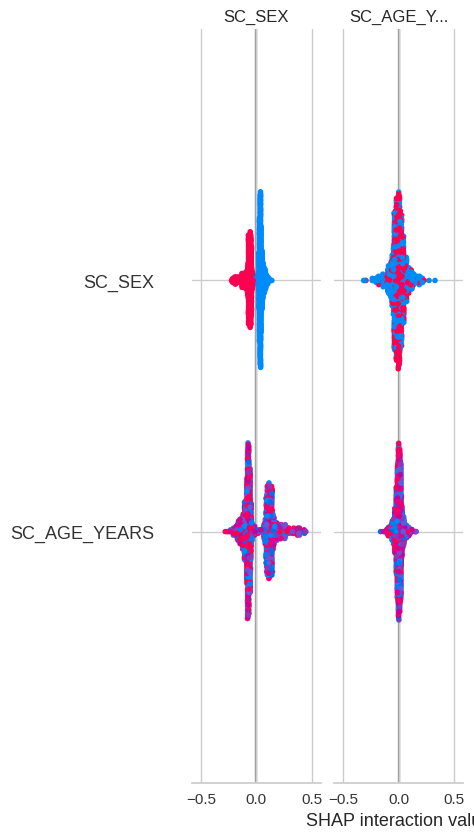

In [33]:
# Adjust max_display to show more features
shap.summary_plot(shap_values_tn_asd, mulx_tn_asd, feature_names=mulX_test1.columns, max_display=10)

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


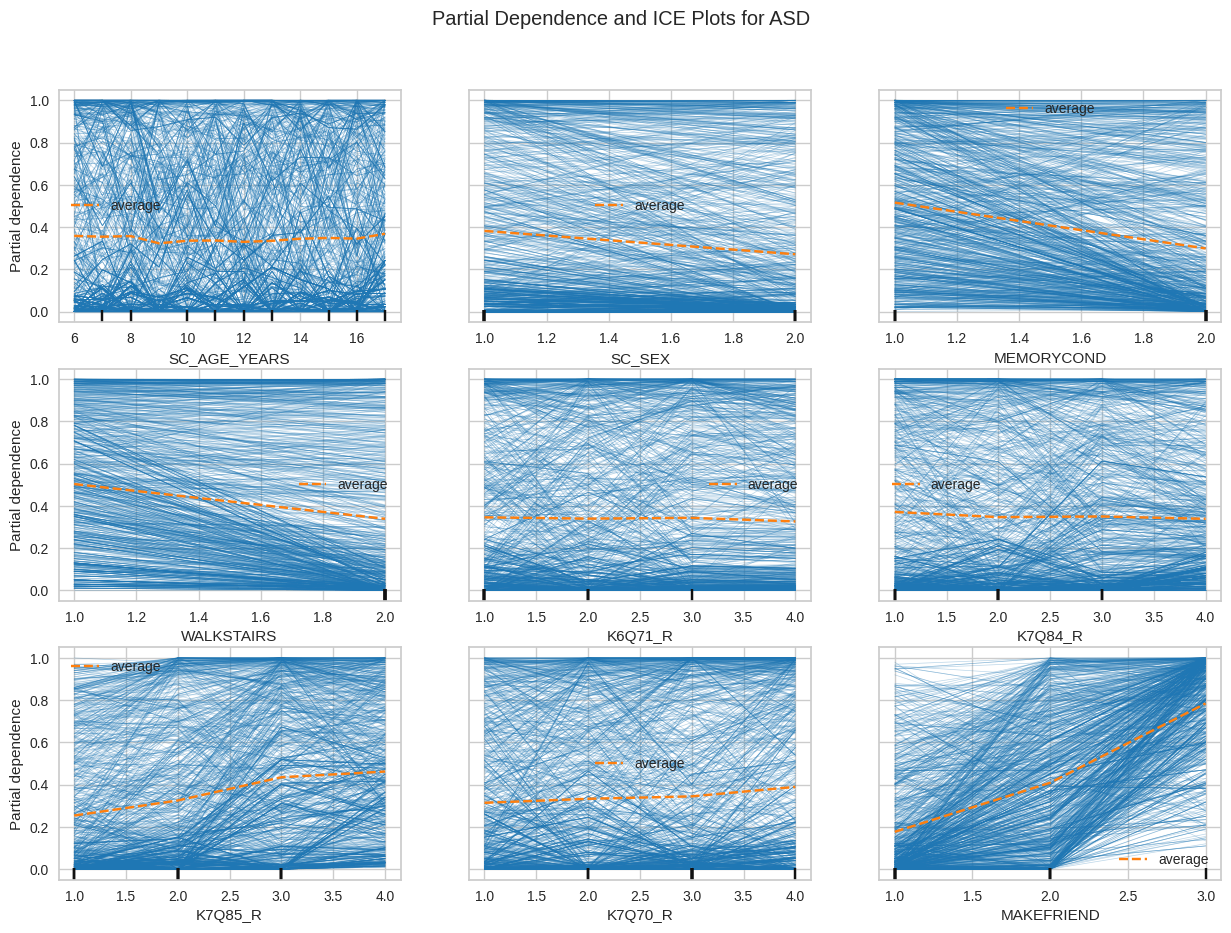

In [40]:
# PDP and ICE for ASD prediction
fig, ax = plt.subplots(figsize=(15, 10))
PartialDependenceDisplay.from_estimator(clf_ee.estimators_[0], mulX_test1,
                                        features=[0, 1, 2, 3, 4, 5, 6, 7, 8],
                                        feature_names=mulX_test1.columns, kind="both", ax=ax)
plt.suptitle("Partial Dependence and ICE Plots for ASD")
plt.subplots_adjust(top=0.9)
plt.show()


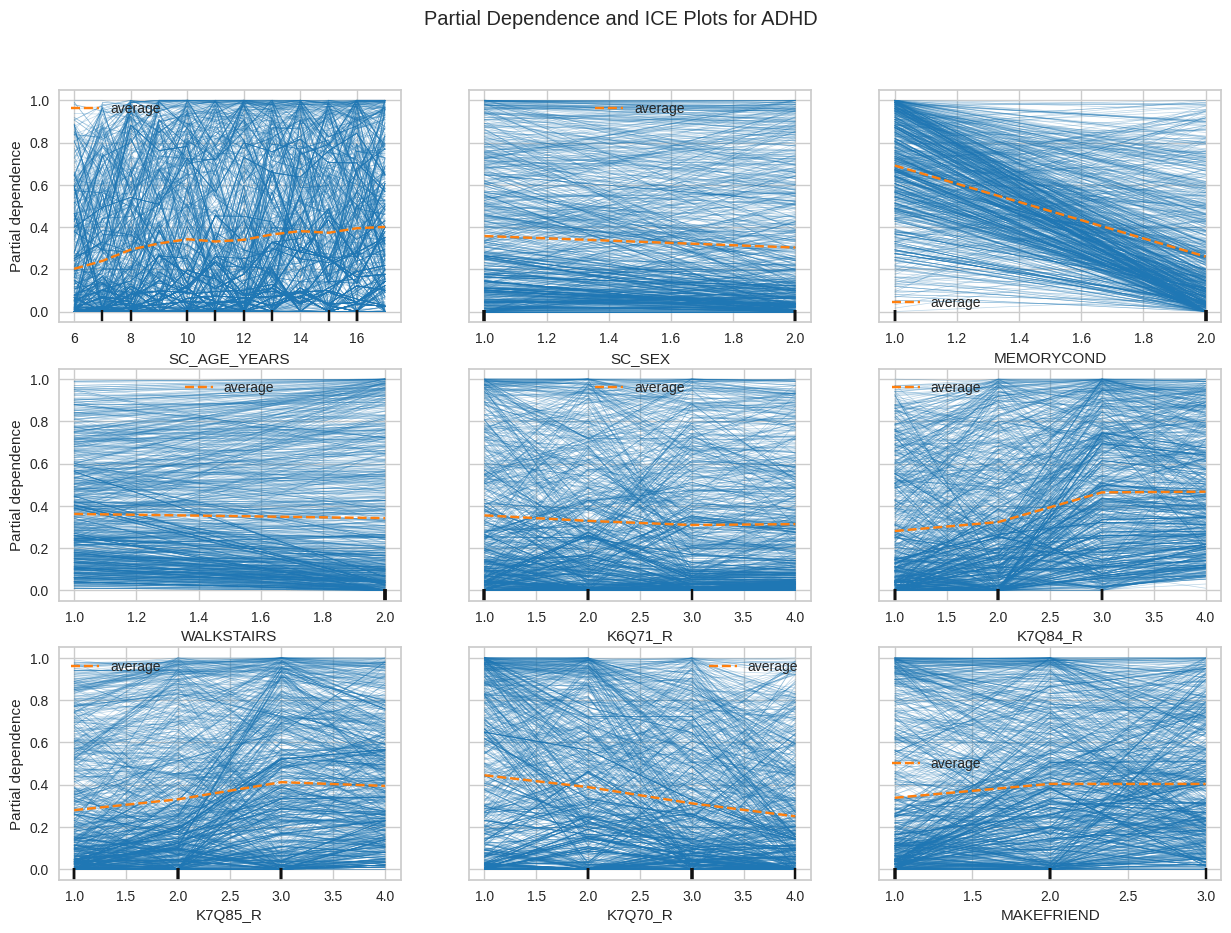

In [41]:
# PDP and ICE for ADHD prediction
fig, ax = plt.subplots(figsize=(15, 10))
PartialDependenceDisplay.from_estimator(clf_ee.estimators_[1], mulx_val1,
                                        features=[0, 1, 2, 3, 4, 5, 6, 7, 8],
                                        feature_names=mulX1.columns, kind="both", ax=ax)
plt.suptitle("Partial Dependence and ICE Plots for ADHD")
plt.subplots_adjust(top=0.9)
plt.show()

In [64]:
# Calculate average SHAP values for false positives
average_shap_fp_asd = np.mean(np.abs(shap_values_fp_asd), axis=0)
average_shap_fp_adhd = np.mean(np.abs(shap_values_fp_adhd), axis=0)

# Calculate average SHAP values for true negatives
average_shap_tn_asd = np.mean(np.abs(shap_values_tn_asd), axis=0)
average_shap_tn_adhd = np.mean(np.abs(shap_values_tn_adhd), axis=0)

# Create DataFrames for easier analysis
shap_fp_df_asd = pd.DataFrame({'Feature': mulX1.columns, 'Average SHAP Value (FP ASD)': average_shap_fp_asd})
shap_fp_df_adhd = pd.DataFrame({'Feature': mulX1.columns, 'Average SHAP Value (FP ADHD)': average_shap_fp_adhd})
shap_tn_df_asd = pd.DataFrame({'Feature': mulX1.columns, 'Average SHAP Value (TN ASD)': average_shap_tn_asd})
shap_tn_df_adhd = pd.DataFrame({'Feature': mulX1.columns, 'Average SHAP Value (TN ADHD)': average_shap_tn_adhd})

print("Feature Contributions to False Positives (ASD):\n", shap_fp_df_asd)
print("Feature Contributions to False Positives (ADHD):\n", shap_fp_df_adhd)
print("Feature Contributions to True Negatives (ASD):\n", shap_tn_df_asd)
print("Feature Contributions to True Negatives (ADHD):\n", shap_tn_df_adhd)

ValueError: Per-column arrays must each be 1-dimensional

In [54]:
import shap

# Loop through each label to calculate SHAP values and plot them separately
for i, estimator in enumerate(clf_ee.estimators_):
    # Initialize the SHAP explainer for the specific label
    explainer = shap.TreeExplainer(estimator)

    # Calculate SHAP values for incorrectly predicted instances for this label
    shap_values = explainer.shap_values(incorrect_data)

    # Ensure the SHAP values match the dimension of the features
    if isinstance(shap_values, list):
        shap_values_to_use = shap_values[1]  # Typically use the positive class shap_values[1]
    else:
        shap_values_to_use = shap_values  # Use directly if not a list

    # Visualize SHAP values for the first incorrectly predicted instance
    print(f"Label {mulY_test1[i]} - SHAP Explanation for first incorrect prediction:")

    shap.force_plot(
        explainer.expected_value[1],  # Use expected_value for positive class
        shap_values_to_use[0],  # Select the first incorrect instance's SHAP values
        incorrect_data.iloc[0],  # Corresponding feature data
        feature_names=mulX_test1.columns
    )

Label [1 1] - SHAP Explanation for first incorrect prediction:


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

# End of testing

In [ ]:
mulpred1 = clf1.predict(mulx_val1)

print("Accuracy = ", accuracy_score(muly_val1, mulpred1))

print("Precision score: ", precision_score(muly_val1, mulpred1, average='micro'))
print("Recall (sensitivity)): ", recall_score(muly_val1, mulpred1, average='micro'))

print(multilabel_confusion_matrix(muly_val1, mulpred1))

Accuracy =  0.6688197298884322
Precision score:  0.7521613832853026
Recall (sensitivity)):  0.6820557491289199
[[[1008  124]
  [ 143  428]]

 [[ 992  134]
  [ 222  355]]]


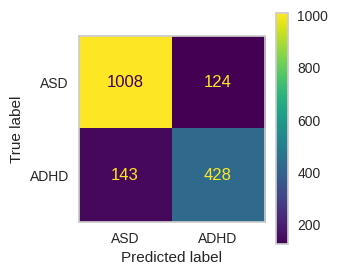

In [ ]:
fig1, ax1 = plt.subplots(figsize=(3, 3))
cmp = ConfusionMatrixDisplay(multilabel_confusion_matrix(muly_val1, mulpred1)[0], display_labels=["ASD", "ADHD"])

cmp.plot(ax=ax1)
ax1.grid(False)
plt.show()

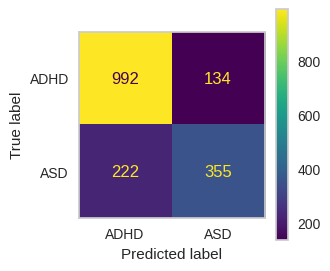

In [ ]:
fig2, ax2 = plt.subplots(figsize=(3, 3))
cmp2 = ConfusionMatrixDisplay(multilabel_confusion_matrix(muly_val1, mulpred1)[1], display_labels=["ADHD", "ASD"])

cmp2.plot(ax=ax2)
ax2.grid(False)
plt.show()

In [ ]:
mulpred1

array([[0, 0],
       [0, 0],
       [0, 0],
       ...,
       [1, 1],
       [0, 0],
       [0, 1]])

In [ ]:
print(roc_auc_score(muly_val1[:,0], mulpred1[:,0]), roc_auc_score(muly_val1[:,1],mulpred1[:,1]))

0.8200107677931593 0.7481229856149435


In [ ]:
print(classification_report(muly_val1[:,0], mulpred1[:,0]))

              precision    recall  f1-score   support

           0       0.87      0.91      0.89      1132
           1       0.81      0.72      0.76       571

    accuracy                           0.85      1703
   macro avg       0.84      0.82      0.83      1703
weighted avg       0.85      0.85      0.85      1703



In [ ]:
print(classification_report(muly_val1[:,1], mulpred1[:,1]))

              precision    recall  f1-score   support

           0       0.81      0.88      0.84      1111
           1       0.73      0.60      0.66       592

    accuracy                           0.79      1703
   macro avg       0.77      0.74      0.75      1703
weighted avg       0.78      0.79      0.78      1703



In [ ]:
ml_prob1 = clf1.predict_proba(mulx_val1)

for i in range(0,10):
 print("True-ASD = %s, True-ADHD = %s, Prob-ASD = %s, Prob-ADHD = %s, Final-ASD-label = %s, Final-ADHD-label = %s" % (muly_val1[i][0], muly_val1[i][1],
                                                                            ml_prob1[0][i], ml_prob1[1][i], np.argmax(ml_prob1[0][i]), np.argmax(ml_prob1[1][i])))

True-ASD = 0, True-ADHD = 0, Prob-ASD = [0.92972793 0.07027207], Prob-ADHD = [0.8705952 0.1294048], Final-ASD-label = 0, Final-ADHD-label = 0
True-ASD = 1, True-ADHD = 0, Prob-ASD = [0.84608824 0.15391176], Prob-ADHD = [0.56633828 0.43366172], Final-ASD-label = 0, Final-ADHD-label = 0
True-ASD = 0, True-ADHD = 0, Prob-ASD = [0.95862508 0.04137492], Prob-ADHD = [0.85995693 0.14004307], Final-ASD-label = 0, Final-ADHD-label = 0
True-ASD = 0, True-ADHD = 0, Prob-ASD = [0.95542169 0.04457831], Prob-ADHD = [0.93732066 0.06267934], Final-ASD-label = 0, Final-ADHD-label = 0
True-ASD = 1, True-ADHD = 0, Prob-ASD = [0.90595021 0.09404979], Prob-ADHD = [0.85403257 0.14596743], Final-ASD-label = 0, Final-ADHD-label = 0
True-ASD = 0, True-ADHD = 0, Prob-ASD = [0.87270386 0.12729614], Prob-ADHD = [0.86830728 0.13169272], Final-ASD-label = 0, Final-ADHD-label = 0
True-ASD = 0, True-ADHD = 0, Prob-ASD = [0.98684028 0.01315972], Prob-ADHD = [0.85500858 0.14499142], Final-ASD-label = 0, Final-ADHD-labe

In [ ]:
pred_list1 = []

for i in range(len(muly_val1)):
  pred_list1.append([muly_val1[i][0], muly_val1[i][1], np.argmax(ml_prob1[0][i]), np.argmax(ml_prob1[1][i])])

In [ ]:
pd.DataFrame(pred_list1, columns = ['True-ASD', 'True-ADHD', 'Final-ASD-Label', 'Final-ADHD-Label'])

True-ASD  True-ADHD  Final-ASD-Label  Final-ADHD-Label
0            0          0                0                 0
1            1          0                0                 0
2            0          0                0                 0
3            0          0                0                 0
4            1          0                0                 0
...        ...        ...              ...               ...
1698         0          0                0                 0
1699         0          0                0                 0
1700         1          1                1                 1
1701         0          1                0                 0
1702         0          0                0                 1

[1703 rows x 4 columns]

In [ ]:
multest1 = clf1.predict(mulX_test1)       ## predicting on test set

print("Accuracy = ", accuracy_score(mulY_test1, multest1))
print("Precision score: ", precision_score(mulY_test1, multest1, average='micro'))
print("Recall (sensitivity)): ", recall_score(mulY_test1, multest1, average='micro'))
print("Specificity: ", recall_score(mulY_test1, multest1, pos_label=0, average='micro'))

print("F1-score: ", f1_score(mulY_test1, multest1, average='micro'))

print(multilabel_confusion_matrix(mulY_test1, multest1))

Accuracy =  0.6797040169133193
Precision score:  0.7781721384205856
Recall (sensitivity)):  0.6715160796324655
Specificity:  0.6715160796324655
F1-score:  0.7209206740649404
[[[1151   96]
  [ 165  480]]

 [[1077  154]
  [ 264  397]]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


In [ ]:
print(roc_auc_score(mulY_test1[:,0], multest1[:,0]), roc_auc_score(mulY_test1[:,1],multest1[:,1]))

0.8336006415396953 0.7377518001305164


### Trying multiclass classification

In [ ]:
mulclass1 = updated_df1.copy()

asd11 = mulclass1[(mulclass1['K2Q35A']==1) & (mulclass1['K2Q31A']==2) & (~mulclass1.index.isin(both11.index))]
asd11['target_diag'] = 0

adhd11 = mulclass1[(mulclass1['K2Q35A']==2) & (mulclass1['K2Q31A']==1) & (~mulclass1.index.isin(both11.index)) & (~mulclass1.index.isin(asd11.index))]
adhd11['target_diag'] = 1

both11 = mulclass1[(mulclass1['K2Q35A']==1) & (mulclass1['K2Q31A']==1)]
both11['target_diag'] = 2

none11 = is_none1.sample((2*asd11.shape[0] + both11.shape[0]), random_state=4)
none11 = none11.drop('target', axis=1)
none11['target_diag']=3

print(both11.shape, asd11.shape, adhd11.shape, none11.shape)

(3421, 20) (3019, 20) (21403, 20) (9459, 20)


<ipython-input-18-b80bca4cd4f6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  asd11['target_diag'] = 0
<ipython-input-18-b80bca4cd4f6>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adhd11['target_diag'] = 1
<ipython-input-18-b80bca4cd4f6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#return

In [ ]:
fourwaydf1 = pd.concat([both11, asd11, adhd11.sample(asd11.shape[0], random_state=20), none11])
fourwaydf1 = fourwaydf1.sample(frac=1)
fourwaydf1.shape

(18918, 20)

In [ ]:
fourwayX1 = fourwaydf1[['SC_AGE_YEARS', 'SC_SEX', 'MEMORYCOND', 'WALKSTAIRS', 'K6Q71_R', 'K7Q84_R', 'K7Q85_R', 'K7Q70_R', 'MAKEFRIEND']]
fourwayY1 = fourwaydf1['target_diag']

In [ ]:
fourwayX_tr1, fourwayX_test1, fourwayY_tr1, fourwayY_test1 = train_test_split(fourwayX1, fourwayY1, random_state=6, test_size=0.10, shuffle=True)
fourwayx_train1, fourwayx_val1, fourwayy_train1, fourwayy_val1 = train_test_split(fourwayX_tr1, fourwayY_tr1, random_state=2, test_size=0.10, shuffle=True)

In [ ]:
fourway_dt = DecisionTreeClassifier(max_depth = 5)

fourway_dt.fit(fourwayx_train1, fourwayy_train1)

DecisionTreeClassifier(max_depth=5)

In [ ]:
fourwaypred1 = fourway_dt.predict(fourwayx_val1)

print("Accuracy = ", accuracy_score(fourwayy_val1, fourwaypred1))

print("Precision score: ", precision_score(fourwayy_val1, fourwaypred1, average='micro'))
print("Recall (sensitivity)): ", recall_score(fourwayy_val1, fourwaypred1, average='micro'))

print(classification_report(fourwayy_val1, fourwaypred1))

Accuracy =  0.6776277157956547
Precision score:  0.6776277157956547
Recall (sensitivity)):  0.6776277157956547
              precision    recall  f1-score   support

           0       0.45      0.21      0.29       287
           1       0.55      0.26      0.35       260
           2       0.51      0.66      0.58       306
           3       0.78      0.97      0.87       850

    accuracy                           0.68      1703
   macro avg       0.57      0.52      0.52      1703
weighted avg       0.64      0.68      0.64      1703



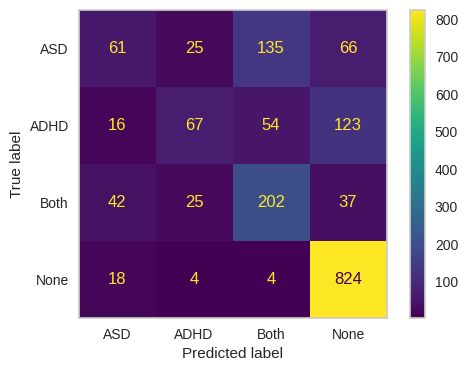

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
cmp = ConfusionMatrixDisplay(confusion_matrix(fourwayy_val1, fourwaypred1), display_labels=["ASD", "ADHD", "Both", "None"],)

cmp.plot(ax=ax)
ax.grid(False)
plt.show()

## ML for different classifications from feature set 2

### Any developmental delay vs none

In [ ]:
updated_df2.head()

SC_AGE_YEARS  SC_SEX  K2Q30A  K2Q31A  K2Q32A  K2Q33A  K2Q34A  K2Q35A  \
30            1.0     1.0     2.0     2.0     2.0     2.0     2.0     2.0   
251           1.0     1.0     2.0     2.0     2.0     2.0     2.0     2.0   
320           0.0     2.0     2.0     2.0     2.0     2.0     2.0     2.0   
352           1.0     1.0     2.0     2.0     2.0     2.0     2.0     2.0   
359           1.0     1.0     2.0     2.0     2.0     2.0     2.0     2.0   

     K2Q36A  K2Q37A  K2Q38A  K2Q60A  K6Q13A  K6Q13B  K6Q71_R  COORDINATION  \
30      2.0     2.0     2.0     2.0     1.0     1.0      1.0           2.0   
251     2.0     2.0     2.0     2.0     1.0     1.0      1.0           2.0   
320     2.0     2.0     2.0     2.0     1.0     1.0      1.0           2.0   
352     2.0     2.0     2.0     2.0     1.0     1.0      1.0           2.0   
359     2.0     2.0     2.0     2.0     1.0     1.0      1.0           2.0   

     K6Q70_R  K6Q73_R  K6Q72_R  
30       1.0      1.0      1.0  
251      1.0      1.0      1.0  
320      1.0      1.0      1.0  
352      1.0      1.0      1.0  
359      1.0      1.0      1.0

In [ ]:
dev2 = updated_df2[(updated_df2['K2Q30A'] == 1) | (updated_df2['K2Q31A'] == 1) | (updated_df2['K2Q32A'] == 1) | (updated_df2['K2Q33A'] == 1) |
                   (updated_df2['K2Q34A'] == 1) | (updated_df2['K2Q35A'] == 1) | (updated_df2['K2Q36A'] == 1) | (updated_df2['K2Q37A'] == 1) |
                   (updated_df2['K2Q38A'] == 1) | (updated_df2['K2Q60A'] == 1)]
dev2['is_any_disab'] = 1

no_dev2 = updated_df2[(updated_df2['K2Q30A'] == 2) & (updated_df2['K2Q31A'] == 2) & (updated_df2['K2Q32A'] == 2) & (updated_df2['K2Q33A'] == 2) &
                      (updated_df2['K2Q34A'] == 2) & (updated_df2['K2Q35A'] == 2) & (updated_df2['K2Q36A'] == 2) & (updated_df2['K2Q37A'] == 2) &
                      (updated_df2['K2Q38A'] == 2) & (updated_df2['K2Q60A'] == 2)]
no_dev2['is_any_disab'] = 0


print(dev2.shape, no_dev2.shape)

(520, 20) (5638, 20)


<ipython-input-34-e2aaec1c961b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dev2['is_any_disab'] = 1
<ipython-input-34-e2aaec1c961b>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_dev2['is_any_disab'] = 0


In [ ]:
all_del2 = pd.concat([dev2, no_dev2.sample(dev2.shape[0], random_state=1)])
all_del2 = all_del2.sample(frac=1)
all_del2.reset_index(drop=True, inplace=True)

In [ ]:
all_del2[['SC_AGE_YEARS', 'SC_SEX', 'K6Q13A', 'K6Q13B', 'K6Q71_R', 'COORDINATION', 'K6Q70_R',
          'K6Q73_R', 'K6Q72_R']].corr().style.background_gradient(cmap='coolwarm')

In [ ]:
any_delay_X2 = all_del2[['SC_AGE_YEARS', 'SC_SEX', 'K6Q13A', 'K6Q13B', 'K6Q71_R', 'COORDINATION', 'K6Q70_R', 'K6Q73_R', 'K6Q72_R']]
any_delay_Y2 = all_del2['is_any_disab']

In [ ]:
any_del_X_tr2, any_del_X_test2, any_del_Y_tr2, any_del_Y_test2 = train_test_split(any_delay_X2, any_delay_Y2, random_state=42, test_size=0.10, shuffle=True)
any_del_xtr2, any_del_xval2, any_del_ytr2, any_del_yval2 = train_test_split(any_del_X_tr2, any_del_Y_tr2, random_state=42, test_size=0.10, shuffle=True)

In [ ]:
dt_model.fit(any_del_xtr2, any_del_ytr2)

any_del_ypred2 = dt_model.predict(any_del_xval2)

In [ ]:
print("Accuracy = ", accuracy_score(any_del_yval2, any_del_ypred2))
print("Precision score: ", precision_score(any_del_yval2, any_del_ypred2))
print("Recall (sensitivity)): ", recall_score(any_del_yval2, any_del_ypred2))
print("Specificity: ", recall_score(any_del_yval2, any_del_ypred2, pos_label=0))

print("F1-score: ", f1_score(any_del_yval2, any_del_ypred2))
print(f"ROC AUC: {roc_auc_score(any_del_yval2, any_del_ypred2)}\n")
print(classification_report(any_del_yval2, any_del_ypred2))

Accuracy =  0.7340425531914894
Precision score:  0.84375
Recall (sensitivity)):  0.574468085106383
Specificity:  0.8936170212765957
F1-score:  0.6835443037974684
ROC AUC: 0.7340425531914893

              precision    recall  f1-score   support

           0       0.68      0.89      0.77        47
           1       0.84      0.57      0.68        47

    accuracy                           0.73        94
   macro avg       0.76      0.73      0.73        94
weighted avg       0.76      0.73      0.73        94



In [ ]:
lr_model.fit(any_del_xtr2, any_del_ytr2)

ypr2 = lr_model.predict(any_del_xval2)

In [ ]:
print("Accuracy = ", accuracy_score(any_del_yval2, ypr2))
print("Precision score: ", precision_score(any_del_yval2, ypr2))
print("Recall (sensitivity)): ", recall_score(any_del_yval2, ypr2))
print("Specificity: ", recall_score(any_del_yval2, ypr2, pos_label=0))

print("F1-score: ", f1_score(any_del_yval2, ypr2))
print(f"ROC AUC: {roc_auc_score(any_del_yval2, ypr2)}\n")
print(classification_report(any_del_yval2, ypr2))

Accuracy =  0.7446808510638298
Precision score:  0.8285714285714286
Recall (sensitivity)):  0.6170212765957447
Specificity:  0.8723404255319149
F1-score:  0.7073170731707318
ROC AUC: 0.7446808510638299

              precision    recall  f1-score   support

           0       0.69      0.87      0.77        47
           1       0.83      0.62      0.71        47

    accuracy                           0.74        94
   macro avg       0.76      0.74      0.74        94
weighted avg       0.76      0.74      0.74        94



In [ ]:
test2 = lr_model.predict(any_del_X_test2)       ## predicting on test set

print("Accuracy = ", accuracy_score(any_del_Y_test2, test2))
print("Precision score: ", precision_score(any_del_Y_test2, test2))
print("Recall (sensitivity)): ", recall_score(any_del_Y_test2, test2))
print("Specificity: ", recall_score(any_del_Y_test2, test2, pos_label=0))

print("F1-score: ", f1_score(any_del_Y_test2, test2))
print(f"ROC AUC: {roc_auc_score(any_del_Y_test2, test2)}\n")
print(classification_report(any_del_Y_test2, test2))

Accuracy =  0.7692307692307693
Precision score:  0.851063829787234
Recall (sensitivity)):  0.7017543859649122
Specificity:  0.851063829787234
F1-score:  0.7692307692307693
ROC AUC: 0.7764091078760732

              precision    recall  f1-score   support

           0       0.70      0.85      0.77        47
           1       0.85      0.70      0.77        57

    accuracy                           0.77       104
   macro avg       0.78      0.78      0.77       104
weighted avg       0.78      0.77      0.77       104



In [ ]:
## testing ASD or ADHD vs none

is_asd_adhd2 = updated_df2[(updated_df2['K2Q35A']==1) | (updated_df2['K2Q31A']==1)]
is_asd_adhd2['target']=1

is_none2 = updated_df2[(updated_df2['K2Q30A'] == 2) & (updated_df2['K2Q31A'] == 2) & (updated_df2['K2Q32A'] == 2) & (updated_df2['K2Q33A'] == 2) &
                      (updated_df2['K2Q34A'] == 2) & (updated_df2['K2Q35A'] == 2) & (updated_df2['K2Q36A'] == 2) & (updated_df2['K2Q37A'] == 2) &
                      (updated_df2['K2Q38A'] == 2) & (updated_df2['K2Q60A'] == 2)]
is_none2['target']=0

<ipython-input-35-d10b17246f6e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  is_asd_adhd2['target']=1
<ipython-input-35-d10b17246f6e>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  is_none2['target']=0


In [ ]:
binclf2 = pd.concat([is_asd_adhd2, is_none2.sample(is_asd_adhd2.shape[0], random_state=2)])
binclf2 = binclf2.sample(frac=1)

In [ ]:
binclf2.shape

(30, 20)

This one does not have enough samples to try ML

## ML for different classifications from feature set 3

### Any developmental delay vs none

In [ ]:
updated_df3.head()

SC_AGE_YEARS  SC_SEX  K2Q30A  K2Q31A  K2Q32A  K2Q33A  K2Q34A  K2Q35A  \
13           4.0     2.0     2.0     2.0     2.0     2.0     2.0     2.0   
14           3.0     1.0     2.0     2.0     2.0     2.0     2.0     2.0   
27           5.0     2.0     2.0     2.0     2.0     2.0     2.0     2.0   
31           5.0     1.0     2.0     2.0     2.0     2.0     2.0     2.0   
37           5.0     2.0     2.0     2.0     2.0     2.0     2.0     2.0   

    K2Q36A  K2Q37A  ...  K6Q70_R  K6Q73_R  K6Q72_R  RECOGBEGIN  RECOGABC  \
13     2.0     2.0  ...      1.0      1.0      1.0         1.0       2.0   
14     2.0     2.0  ...      1.0      1.0      1.0         1.0       1.0   
27     2.0     2.0  ...      1.0      2.0      1.0         1.0       1.0   
31     2.0     2.0  ...      1.0      1.0      1.0         1.0       1.0   
37     2.0     2.0  ...      1.0      1.0      1.0         2.0       2.0   

    CLEAREXP  WRITENAME  DISTRACTED  PLAYWELL  HURTSAD  
13       1.0        4.0         4.0       2.0      2.0  
14       1.0        2.0         3.0       2.0      2.0  
27       1.0        1.0         3.0       2.0      1.0  
31       1.0        1.0         3.0       2.0      2.0  
37       3.0        1.0         3.0       1.0      2.0  

[5 rows x 25 columns]

In [ ]:
dev3 = updated_df3[(updated_df3['K2Q30A'] == 1) | (updated_df3['K2Q31A'] == 1) | (updated_df3['K2Q32A'] == 1) | (updated_df3['K2Q33A'] == 1) |
                   (updated_df3['K2Q34A'] == 1) | (updated_df3['K2Q35A'] == 1) | (updated_df3['K2Q36A'] == 1) | (updated_df3['K2Q37A'] == 1) |
                   (updated_df3['K2Q38A'] == 1) | (updated_df3['K2Q60A'] == 1)]
dev3['is_any_disab'] = 1

no_dev3 = updated_df3[(updated_df3['K2Q30A'] == 2) & (updated_df3['K2Q31A'] == 2) & (updated_df3['K2Q32A'] == 2) & (updated_df3['K2Q33A'] == 2) &
                      (updated_df3['K2Q34A'] == 2) & (updated_df3['K2Q35A'] == 2) & (updated_df3['K2Q36A'] == 2) & (updated_df3['K2Q37A'] == 2) &
                      (updated_df3['K2Q38A'] == 2) & (updated_df3['K2Q60A'] == 2)]
no_dev3['is_any_disab'] = 0


print(dev3.shape, no_dev3.shape)

(5586, 26) (30303, 26)


<ipython-input-36-347a4c484b54>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dev3['is_any_disab'] = 1
<ipython-input-36-347a4c484b54>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_dev3['is_any_disab'] = 0


In [ ]:
all_del3 = pd.concat([dev3, no_dev3.sample(dev3.shape[0], random_state=1)])
all_del3 = all_del3.sample(frac=1)
all_del3.reset_index(drop=True, inplace=True)

In [ ]:
all_del3.columns.values

array(['SC_AGE_YEARS', 'SC_SEX', 'K2Q30A', 'K2Q31A', 'K2Q32A', 'K2Q33A',
       'K2Q34A', 'K2Q35A', 'K2Q36A', 'K2Q37A', 'K2Q38A', 'K2Q60A',
       'K6Q71_R', 'MAKEFRIEND', 'K6Q14A', 'K6Q14B', 'COORDINATION',
       'K6Q70_R', 'K6Q73_R', 'K6Q72_R', 'RECOGBEGIN', 'RECOGABC',
       'CLEAREXP', 'WRITENAME', 'DISTRACTED', 'PLAYWELL', 'HURTSAD',
       'is_any_disab'], dtype=object)

In [ ]:
all_del3[['SC_AGE_YEARS', 'SC_SEX', 'K6Q71_R', 'MAKEFRIEND', 'COORDINATION','K6Q70_R', 'K6Q73_R','K6Q72_R', 'RECOGBEGIN',
          'RECOGABC','CLEAREXP', 'WRITENAME', 'DISTRACTED', 'PLAYWELL', 'HURTSAD']].corr().style.background_gradient(cmap='coolwarm')

In [ ]:
any_delay_X3 = all_del3[['SC_AGE_YEARS', 'SC_SEX', 'K6Q71_R', 'MAKEFRIEND', 'COORDINATION','K6Q70_R', 'K6Q73_R',
                         'K6Q72_R', 'RECOGBEGIN', 'RECOGABC','CLEAREXP', 'WRITENAME', 'DISTRACTED', 'PLAYWELL', 'HURTSAD']]
any_delay_Y3 = all_del3['is_any_disab']

In [ ]:
any_del_X_tr3, any_del_X_test3, any_del_Y_tr3, any_del_Y_test3 = train_test_split(any_delay_X3, any_delay_Y3, random_state=42, test_size=0.10, shuffle=True)
any_del_xtr3, any_del_xval3, any_del_ytr3, any_del_yval3 = train_test_split(any_del_X_tr3, any_del_Y_tr3, random_state=42, test_size=0.10, shuffle=True)

In [ ]:
dt_model.fit(any_del_xtr3, any_del_ytr3)

any_del_ypred3 = dt_model.predict(any_del_xval3)

In [ ]:
print("Accuracy = ", accuracy_score(any_del_yval3, any_del_ypred3))
print("Precision score: ", precision_score(any_del_yval3, any_del_ypred3))
print("Recall (sensitivity)): ", recall_score(any_del_yval3, any_del_ypred3))
print("Specificity: ", recall_score(any_del_yval3, any_del_ypred3, pos_label=0))

print("F1-score: ", f1_score(any_del_yval3, any_del_ypred3))
print(f"ROC AUC: {roc_auc_score(any_del_yval3, any_del_ypred3)}\n")
print(classification_report(any_del_yval3, any_del_ypred3))

Accuracy =  0.7296786389413988
Precision score:  0.7912087912087912
Recall (sensitivity)):  0.5783132530120482
Specificity:  0.8642857142857143
F1-score:  0.6682134570765661
ROC AUC: 0.7212994836488813

              precision    recall  f1-score   support

           0       0.70      0.86      0.77       280
           1       0.79      0.58      0.67       249

    accuracy                           0.73       529
   macro avg       0.74      0.72      0.72       529
weighted avg       0.74      0.73      0.72       529



In [ ]:
lr_model.fit(any_del_xtr3, any_del_ytr3)

ypr3 = lr_model.predict(any_del_xval3)

In [ ]:
print("Accuracy = ", accuracy_score(any_del_yval3, ypr3))
print("Precision score: ", precision_score(any_del_yval3, ypr3))
print("Recall (sensitivity)): ", recall_score(any_del_yval3, ypr3))
print("Specificity: ", recall_score(any_del_yval3, ypr3, pos_label=0))

print("F1-score: ", f1_score(any_del_yval3, ypr3))
print(f"ROC AUC: {roc_auc_score(any_del_yval3, ypr3)}\n")
print(classification_report(any_del_yval3, ypr3))

Accuracy =  0.775047258979206
Precision score:  0.8009259259259259
Recall (sensitivity)):  0.6947791164658634
Specificity:  0.8464285714285714
F1-score:  0.7440860215053764
ROC AUC: 0.7706038439472174

              precision    recall  f1-score   support

           0       0.76      0.85      0.80       280
           1       0.80      0.69      0.74       249

    accuracy                           0.78       529
   macro avg       0.78      0.77      0.77       529
weighted avg       0.78      0.78      0.77       529



In [ ]:
test3 = lr_model.predict(any_del_X_test3)       ## predicting on test set

print("Accuracy = ", accuracy_score(any_del_Y_test3, test3))
print("Precision score: ", precision_score(any_del_Y_test3, test3))
print("Recall (sensitivity)): ", recall_score(any_del_Y_test3, test3))
print("Specificity: ", recall_score(any_del_Y_test3, test3, pos_label=0))

print("F1-score: ", f1_score(any_del_Y_test3, test3))
print(f"ROC AUC: {roc_auc_score(any_del_Y_test3, test3)}\n")
print(classification_report(any_del_Y_test3, test3))

Accuracy =  0.7334525939177102
Precision score:  0.7649402390438247
Recall (sensitivity)):  0.6808510638297872
Specificity:  0.7870036101083032
F1-score:  0.7204502814258912
ROC AUC: 0.7339273369690453

              precision    recall  f1-score   support

           0       0.71      0.79      0.75       554
           1       0.76      0.68      0.72       564

    accuracy                           0.73      1118
   macro avg       0.74      0.73      0.73      1118
weighted avg       0.74      0.73      0.73      1118



In [ ]:
## testing ASD or ADHD vs none

is_asd_adhd3 = updated_df3[(updated_df3['K2Q35A']==1) | (updated_df3['K2Q31A']==1)]
is_asd_adhd3['target']=1

is_none3 = updated_df3[(updated_df3['K2Q30A'] == 2) & (updated_df3['K2Q31A'] == 2) & (updated_df3['K2Q32A'] == 2) & (updated_df3['K2Q33A'] == 2) &
                      (updated_df3['K2Q34A'] == 2) & (updated_df3['K2Q35A'] == 2) & (updated_df3['K2Q36A'] == 2) & (updated_df3['K2Q37A'] == 2) &
                      (updated_df3['K2Q38A'] == 2) & (updated_df3['K2Q60A'] == 2)]
is_none3['target']=0

<ipython-input-37-fbb4f0800efd>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  is_asd_adhd3['target']=1
<ipython-input-37-fbb4f0800efd>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  is_none3['target']=0


In [ ]:
binclf3 = pd.concat([is_asd_adhd3, is_none3.sample(is_asd_adhd3.shape[0], random_state=2)])
binclf3 = binclf3.sample(frac=1)

In [ ]:
binclf3.shape

(1730, 28)

In [ ]:
binclf3.columns.values

array(['SC_AGE_YEARS', 'SC_SEX', 'K2Q30A', 'K2Q31A', 'K2Q32A', 'K2Q33A',
       'K2Q34A', 'K2Q35A', 'K2Q36A', 'K2Q37A', 'K2Q38A', 'K2Q60A',
       'K6Q71_R', 'MAKEFRIEND', 'K6Q14A', 'K6Q14B', 'COORDINATION',
       'K6Q70_R', 'K6Q73_R', 'K6Q72_R', 'RECOGBEGIN', 'RECOGABC',
       'CLEAREXP', 'WRITENAME', 'DISTRACTED', 'PLAYWELL', 'HURTSAD',
       'target'], dtype=object)

In [ ]:
fX3 = binclf3[['SC_AGE_YEARS', 'SC_SEX', 'K6Q71_R', 'MAKEFRIEND', 'COORDINATION','K6Q70_R', 'K6Q73_R',
              'K6Q72_R', 'RECOGBEGIN', 'RECOGABC','CLEAREXP', 'WRITENAME', 'DISTRACTED', 'PLAYWELL', 'HURTSAD']]
fY3 = binclf3['target']

fX_tr3, fX_test3, fY_tr3, fY_test3 = train_test_split(fX3, fY3, random_state=42, test_size=0.10, shuffle=True)
fx_train3, fx_val3, fy_train3, fy_val3 = train_test_split(fX_tr3, fY_tr3, random_state=20, test_size=0.10, shuffle=True)

In [ ]:
dt_model.fit(fx_train3, fy_train3)

asd_adhd_pred3 = dt_model.predict(fx_val3)

In [ ]:
print("Accuracy = ", accuracy_score(fy_val3, asd_adhd_pred3))
print("Precision score: ", precision_score(fy_val3, asd_adhd_pred3))
print("Recall (sensitivity)): ", recall_score(fy_val3, asd_adhd_pred3))
print("Specificity: ", recall_score(fy_val3, asd_adhd_pred3, pos_label=0))

print("F1-score: ", f1_score(fy_val3, asd_adhd_pred3))
print(f"ROC AUC: {roc_auc_score(fy_val3, asd_adhd_pred3)}\n")
print(classification_report(fy_val3, asd_adhd_pred3))

Accuracy =  0.9102564102564102
Precision score:  0.9058823529411765
Recall (sensitivity)):  0.927710843373494
Specificity:  0.8904109589041096
F1-score:  0.9166666666666667
ROC AUC: 0.9090609011388018

              precision    recall  f1-score   support

           0       0.92      0.89      0.90        73
           1       0.91      0.93      0.92        83

    accuracy                           0.91       156
   macro avg       0.91      0.91      0.91       156
weighted avg       0.91      0.91      0.91       156



<Axes: ylabel='None'>

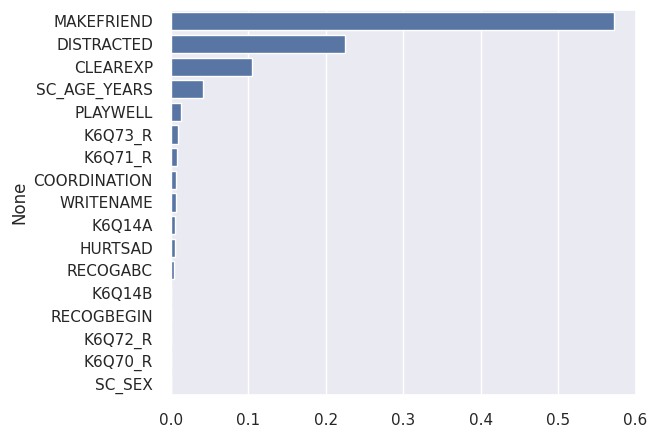

In [ ]:
feat_imp3 = dt_model.feature_importances_

sorted_ind3 = feat_imp3.argsort()[::-1]
sorted_feat_names3 = fx_train3.columns[sorted_ind3]
sorted_imp3 = feat_imp3[sorted_ind3]

sns.set(rc={'figure.figsize':(6,5)})
sns.barplot(x=sorted_imp3, y=sorted_feat_names3)

In [ ]:
lr_model.fit(fx_train3, fy_train3)

asd_adhd_logpred3 = lr_model.predict(fx_val3)

In [ ]:
print("Accuracy = ", accuracy_score(fy_val3, asd_adhd_logpred3))
print("Precision score: ", precision_score(fy_val3, asd_adhd_logpred3))
print("Recall (sensitivity)): ", recall_score(fy_val3, asd_adhd_logpred3))
print("Specificity: ", recall_score(fy_val3, asd_adhd_logpred3, pos_label=0))

print("F1-score: ", f1_score(fy_val3, asd_adhd_logpred3))
print(f"ROC AUC: {roc_auc_score(fy_val3, asd_adhd_logpred3)}\n")
print(classification_report(fy_val3, asd_adhd_logpred3))

Accuracy =  0.9117647058823529
Precision score:  0.9150943396226415
Recall (sensitivity)):  0.8899082568807339
Specificity:  0.9302325581395349
F1-score:  0.9023255813953488
ROC AUC: 0.9100704075101345

              precision    recall  f1-score   support

           0       0.91      0.93      0.92       129
           1       0.92      0.89      0.90       109

    accuracy                           0.91       238
   macro avg       0.91      0.91      0.91       238
weighted avg       0.91      0.91      0.91       238



<Axes: ylabel='Feature'>

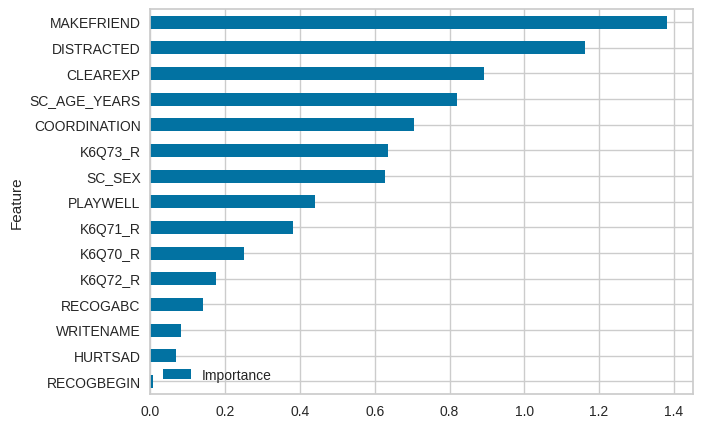

In [ ]:
log_coef3 = lr_model.coef_[0]

log_feature_importance3 = pd.DataFrame({'Feature': fx_val3.columns, 'Importance': np.abs(log_coef3)})
log_feature_importance3 = log_feature_importance3.sort_values('Importance', ascending=True)
log_feature_importance3.plot(x='Feature', y='Importance', kind='barh', figsize=(7, 5))

https://forecastegy.com/posts/feature-importance-in-logistic-regression/

In [ ]:
fftest3 = lr_model.predict(fX_test3)       ## predicting on test set

print("Accuracy = ", accuracy_score(fY_test3, fftest3))
print("Precision score: ", precision_score(fY_test3, fftest3))
print("Recall (sensitivity)): ", recall_score(fY_test3, fftest3))
print("Specificity: ", recall_score(fY_test3, fftest3, pos_label=0))

print("F1-score: ", f1_score(fY_test3, fftest3))
print(f"ROC AUC: {roc_auc_score(fY_test3, fftest3)}\n")
print(classification_report(fY_test3, fftest3))

Accuracy =  0.8977272727272727
Precision score:  0.8947368421052632
Recall (sensitivity)):  0.8717948717948718
Specificity:  0.9183673469387755
F1-score:  0.8831168831168831
ROC AUC: 0.8950811093668237

              precision    recall  f1-score   support

           0       0.90      0.92      0.91       147
           1       0.89      0.87      0.88       117

    accuracy                           0.90       264
   macro avg       0.90      0.90      0.90       264
weighted avg       0.90      0.90      0.90       264



### Multilabel ASD/ADHD

In [ ]:
mullab3 = updated_df3.copy()
mullab3['ASD'] = np.where(mullab3['K2Q35A']==1, 1, 0)
mullab3['ADHD'] = np.where(mullab3['K2Q31A']==1, 1, 0)

In [ ]:
print(mullab3['ASD'].value_counts(), mullab3['ADHD'].value_counts())

ASD
0    35081
1      808
Name: count, dtype: int64 ADHD
0    35234
1      655
Name: count, dtype: int64


In [ ]:
mullab3[(mullab3['ASD']==1) & (mullab3['ADHD']==1)].shape[0]

145

In [ ]:
both3 = mullab3[(mullab3['ASD']==1) & (mullab3['ADHD']==1)]
asd3 = mullab3[(mullab3['ASD']==1) & (~mullab3.index.isin(both3.index))]
adhd3 = mullab3[(mullab3['ADHD']==1) & (~mullab3.index.isin(both3.index)) & (~mullab3.index.isin(asd3.index))]

## fewer adhd samples here

none3 = is_none3.sample((2*adhd3.shape[0]+both3.shape[0]), random_state=4)
none3['ASD']=0
none3['ADHD']=0
none3 = none3.drop('target', axis=1)

print(both3.shape, asd3.shape, adhd3.shape, none3.shape)

(145, 27) (663, 27) (510, 27) (1165, 27)


In [ ]:
muldf3 = pd.concat([both3, asd3.sample(adhd3.shape[0], random_state=5), adhd3, none3])
muldf3 = muldf3.sample(frac=1)
muldf3.shape

(2330, 27)

In [ ]:
muldf3

SC_AGE_YEARS  SC_SEX  K2Q30A  K2Q31A  K2Q32A  K2Q33A  K2Q34A  K2Q35A  \
103075           4.0     2.0     2.0     2.0     2.0     2.0     2.0     2.0   
179063           5.0     1.0     2.0     1.0     2.0     2.0     1.0     2.0   
60953            4.0     1.0     2.0     2.0     2.0     2.0     2.0     2.0   
95058            5.0     2.0     2.0     2.0     2.0     2.0     2.0     1.0   
150691           4.0     2.0     2.0     2.0     2.0     2.0     2.0     2.0   
...              ...     ...     ...     ...     ...     ...     ...     ...   
204760           4.0     1.0     2.0     2.0     2.0     2.0     2.0     2.0   
145463           3.0     2.0     2.0     2.0     2.0     2.0     1.0     1.0   
95596            4.0     1.0     2.0     1.0     2.0     2.0     1.0     1.0   
110009           4.0     2.0     1.0     1.0     2.0     2.0     1.0     1.0   
31882            3.0     2.0     2.0     2.0     2.0     2.0     2.0     2.0   

        K2Q36A  K2Q37A  ...  K6Q72_R  RECOGBEGIN  RECOGABC  CLEAREXP  \
103075     2.0     2.0  ...      1.0         2.0       1.0       1.0   
179063     2.0     2.0  ...      1.0         3.0       1.0       1.0   
60953      2.0     2.0  ...      2.0         1.0       1.0       2.0   
95058      2.0     2.0  ...      2.0         1.0       1.0       4.0   
150691     2.0     2.0  ...      1.0         1.0       1.0       1.0   
...        ...     ...  ...      ...         ...       ...       ...   
204760     2.0     2.0  ...      1.0         4.0       4.0       1.0   
145463     2.0     1.0  ...      1.0         2.0       4.0       4.0   
95596      2.0     1.0  ...      2.0         3.0       1.0       2.0   
110009     1.0     1.0  ...      1.0         5.0       1.0       5.0   
31882      2.0     2.0  ...      2.0         4.0       3.0       2.0   

        WRITENAME  DISTRACTED  PLAYWELL  HURTSAD  ASD  ADHD  
103075        1.0         4.0       1.0      1.0    0     0  
179063        1.0         2.0       2.0      2.0    0     1  
60953         1.0         3.0       2.0      2.0    0     0  
95058         1.0         4.0       3.0      1.0    1     0  
150691        1.0         3.0       1.0      3.0    0     0  
...           ...         ...       ...      ...  ...   ...  
204760        3.0         4.0       1.0      2.0    0     0  
145463        5.0         3.0       4.0      2.0    1     0  
95596         1.0         2.0       3.0      3.0    1     1  
110009        5.0         1.0       4.0      4.0    1     1  
31882         4.0         2.0       2.0      3.0    0     0  

[2330 rows x 27 columns]

In [ ]:
mulX3 = muldf3[['SC_AGE_YEARS', 'SC_SEX', 'K6Q71_R', 'MAKEFRIEND', 'COORDINATION','K6Q70_R', 'K6Q73_R',
              'K6Q72_R', 'RECOGBEGIN', 'RECOGABC','CLEAREXP', 'WRITENAME', 'DISTRACTED', 'PLAYWELL', 'HURTSAD']]
mulY3 = muldf3[['ASD', 'ADHD']].values

In [ ]:
mulX_tr3, mulX_test3, mulY_tr3, mulY_test3 = train_test_split(mulX3, mulY3, random_state=2, test_size=0.10, shuffle=True)
mulx_train3, mulx_val3, muly_train3, muly_val3 = train_test_split(mulX_tr3, mulY_tr3, random_state=6, test_size=0.10, shuffle=True)

In [ ]:
### using multi output classifier first

clf3 = MultiOutputClassifier(LogisticRegression(max_iter=500,random_state=2))
clf3.fit(mulx_train3, muly_train3)

MultiOutputClassifier(estimator=LogisticRegression(max_iter=500,
                                                   random_state=2))

In [ ]:
clf3 = MultiOutputClassifier(DecisionTreeClassifier(max_depth=5))
clf3.fit(mulx_train3, muly_train3)

MultiOutputClassifier(estimator=DecisionTreeClassifier(max_depth=5))

In [ ]:
feat_impts = []
for c in clf3.estimators_:
    feat_impts.append(c.feature_importances_)

np.mean(feat_impts, axis=0)

array([0.04080482, 0.01346194, 0.00193104, 0.05753389, 0.00273383,
       0.0052104 , 0.00688538, 0.00308096, 0.01566946, 0.03359241,
       0.43488008, 0.00966246, 0.35442145, 0.01056774, 0.00956414])

In [ ]:
mulx_train3.columns

Index(['SC_AGE_YEARS', 'SC_SEX', 'K6Q71_R', 'MAKEFRIEND', 'COORDINATION',
       'K6Q70_R', 'K6Q73_R', 'K6Q72_R', 'RECOGBEGIN', 'RECOGABC', 'CLEAREXP',
       'WRITENAME', 'DISTRACTED', 'PLAYWELL', 'HURTSAD'],
      dtype='object')

In [ ]:
mulpred3 = clf3.predict(mulx_val3)

print("Accuracy = ", accuracy_score(muly_val3, mulpred3))

print("Precision score: ", precision_score(muly_val3, mulpred3, average='micro'))
print("Recall (sensitivity)): ", recall_score(muly_val3, mulpred3, average='micro'))

print(multilabel_confusion_matrix(muly_val3, mulpred3))

Accuracy =  0.7095238095238096
Precision score:  0.7142857142857143
Recall (sensitivity)):  0.5701754385964912
[[[143  11]
  [ 19  37]]

 [[137  15]
  [ 30  28]]]


In [ ]:
print(roc_auc_score(muly_val3[:,0], mulpred3[:,0]), roc_auc_score(muly_val3[:,1],mulpred3[:,1]))

0.7946428571428571 0.6920372050816697


In [ ]:
print(classification_report(muly_val3[:,0], mulpred3[:,0]))

              precision    recall  f1-score   support

           0       0.88      0.93      0.91       154
           1       0.77      0.66      0.71        56

    accuracy                           0.86       210
   macro avg       0.83      0.79      0.81       210
weighted avg       0.85      0.86      0.85       210



In [ ]:
print(classification_report(muly_val3[:,1], mulpred3[:,1]))

              precision    recall  f1-score   support

           0       0.82      0.90      0.86       152
           1       0.65      0.48      0.55        58

    accuracy                           0.79       210
   macro avg       0.74      0.69      0.71       210
weighted avg       0.77      0.79      0.77       210



In [ ]:
ml_prob3 = clf3.predict_proba(mulx_val3)

for i in range(0,10):
 print("True-ASD = %s, True-ADHD = %s, Prob-ASD = %s, Prob-ADHD = %s, Final-ASD-label = %s, Final-ADHD-label = %s" % (muly_val3[i][0], muly_val3[i][1],
                                                                            ml_prob3[0][i], ml_prob3[1][i], np.argmax(ml_prob3[0][i]), np.argmax(ml_prob3[1][i])))

True-ASD = 0, True-ADHD = 1, Prob-ASD = [0.7038262 0.2961738], Prob-ADHD = [0.28859759 0.71140241], Final-ASD-label = 0, Final-ADHD-label = 1
True-ASD = 0, True-ADHD = 0, Prob-ASD = [0.98809748 0.01190252], Prob-ADHD = [0.96795085 0.03204915], Final-ASD-label = 0, Final-ADHD-label = 0
True-ASD = 0, True-ADHD = 0, Prob-ASD = [0.98942437 0.01057563], Prob-ADHD = [0.97252139 0.02747861], Final-ASD-label = 0, Final-ADHD-label = 0
True-ASD = 0, True-ADHD = 0, Prob-ASD = [0.97587118 0.02412882], Prob-ADHD = [0.98294824 0.01705176], Final-ASD-label = 0, Final-ADHD-label = 0
True-ASD = 0, True-ADHD = 0, Prob-ASD = [0.97275623 0.02724377], Prob-ADHD = [0.79221378 0.20778622], Final-ASD-label = 0, Final-ADHD-label = 0
True-ASD = 1, True-ADHD = 0, Prob-ASD = [0.07190666 0.92809334], Prob-ADHD = [0.92053838 0.07946162], Final-ASD-label = 1, Final-ADHD-label = 0
True-ASD = 0, True-ADHD = 1, Prob-ASD = [0.160255 0.839745], Prob-ADHD = [0.77022211 0.22977789], Final-ASD-label = 1, Final-ADHD-label = 

In [ ]:
pred_list3 = []

for i in range(len(muly_val3)):
  pred_list3.append([muly_val3[i][0], muly_val3[i][1], ml_prob3[0][i], ml_prob3[1][i], np.argmax(ml_prob3[0][i]), np.argmax(ml_prob3[1][i])])

In [ ]:
pd.DataFrame(pred_list3, columns = ['True-ASD', 'True-ADHD', 'Prob-ASD', 'Prob-ADHD', 'Final-ASD-Label', 'Final-ADHD-Label'])

True-ASD  True-ADHD                                    Prob-ASD  \
0           0          1   [0.7038262001677151, 0.29617379983228487]   
1           0          0  [0.9880974798279388, 0.011902520172061117]   
2           0          0  [0.9894243693305594, 0.010575630669440577]   
3           0          0  [0.9758711775334196, 0.024128822466580394]   
4           0          0   [0.9727562291162173, 0.02724377088378273]   
..        ...        ...                                         ...   
205         0          1    [0.4446793854000859, 0.5553206145999141]   
206         0          0  [0.9822093979465002, 0.017790602053499752]   
207         0          0   [0.9406024137029486, 0.05939758629705142]   
208         0          1   [0.9085177326071593, 0.09148226739284068]   
209         0          0   [0.9801951703352838, 0.01980482966471625]   

                                       Prob-ADHD  Final-ASD-Label  \
0        [0.28859759046369005, 0.71140240953631]                0   
1      [0.9679508480438257, 0.03204915195617428]                0   
2     [0.9725213859693979, 0.027478614030602123]                0   
3      [0.9829482412266598, 0.01705175877334019]                0   
4       [0.7922137818290033, 0.2077862181709967]                0   
..                                           ...              ...   
205     [0.2661735476929138, 0.7338264523070862]                1   
206    [0.7383478424716423, 0.26165215752835763]                0   
207    [0.8919629175295757, 0.10803708247042429]                0   
208     [0.609262434688517, 0.39073756531148296]                0   
209  [0.9964206451719466, 0.0035793548280533597]                0   

     Final-ADHD-Label  
0                   1  
1                   0  
2                   0  
3                   0  
4                   0  
..                ...  
205                 1  
206                 0  
207                 0  
208                 0  
209                 0  

[210 rows x 6 columns]

In [ ]:
multest3 = clf3.predict(mulX_test3)       ## predicting on test set

print("Accuracy = ", accuracy_score(mulY_test3, multest3))
print("Precision score: ", precision_score(mulY_test3, multest3, average='micro'))
print("Recall (sensitivity)): ", recall_score(mulY_test3, multest3, average='micro'))
print("Specificity: ", recall_score(mulY_test3, multest3, pos_label=0, average='micro'))

print("F1-score: ", f1_score(mulY_test3, multest3, average='micro'))

print(multilabel_confusion_matrix(mulY_test3, multest3))

Accuracy =  0.7339055793991416
Precision score:  0.7735849056603774
Recall (sensitivity)):  0.6356589147286822
Specificity:  0.6356589147286822
F1-score:  0.6978723404255319
[[[166   7]
  [ 19  41]]

 [[147  17]
  [ 28  41]]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


In [ ]:
print(roc_auc_score(mulY_test3[:,0], multest3[:,0]), roc_auc_score(mulY_test3[:,1],multest3[:,1]))

0.8214354527938342 0.7452721809826794


### Trying multiclass classification

In [ ]:
mulclass3 = updated_df3.copy()

both33 = mulclass3[(mulclass3['K2Q35A']==1) & (mulclass3['K2Q31A']==1)]
both33['target_diag'] = 2

asd33 = mulclass3[(mulclass3['K2Q35A']==1) & (mulclass3['K2Q31A']==2) & (~mulclass3.index.isin(both33.index))]
asd33['target_diag'] = 0

adhd33 = mulclass3[(mulclass3['K2Q35A']==2) & (mulclass3['K2Q31A']==1) & (~mulclass3.index.isin(both33.index)) & (~mulclass3.index.isin(asd33.index))]
adhd33['target_diag'] = 1

none33 = is_none3.sample((3*both33.shape[0]), random_state=4)
none33 = none33.drop('target', axis=1)
none33['target_diag']=3

print(both33.shape, asd33.shape, adhd33.shape, none33.shape)

(145, 26) (663, 26) (510, 26) (435, 26)


<ipython-input-40-e652f004948d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  both33['target_diag'] = 2
<ipython-input-40-e652f004948d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  asd33['target_diag'] = 0
<ipython-input-40-e652f004948d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#return

In [ ]:
fourwaydf3 = pd.concat([both33, asd33.sample(both33.shape[0], random_state=4), adhd33.sample(both33.shape[0], random_state=20), none33])
fourwaydf3 = fourwaydf3.sample(frac=1)
fourwaydf3.shape

(870, 26)

In [ ]:
fourwayX3 = fourwaydf3[['SC_AGE_YEARS', 'SC_SEX', 'K6Q71_R', 'MAKEFRIEND', 'COORDINATION','K6Q70_R', 'K6Q73_R',
              'K6Q72_R', 'RECOGBEGIN', 'RECOGABC','CLEAREXP', 'WRITENAME', 'DISTRACTED', 'PLAYWELL', 'HURTSAD']]
fourwayY3 = fourwaydf3['target_diag']

In [ ]:
fourwayX_tr3, fourwayX_test3, fourwayY_tr3, fourwayY_test3 = train_test_split(fourwayX3, fourwayY3, random_state=6, test_size=0.10, shuffle=True)
fourwayx_train3, fourwayx_val3, fourwayy_train3, fourwayy_val3 = train_test_split(fourwayX_tr3, fourwayY_tr3, random_state=2, test_size=0.10, shuffle=True)

In [ ]:
fourway_dt3 = DecisionTreeClassifier(max_depth = 5)

fourway_dt3.fit(fourwayx_train3, fourwayy_train3)

DecisionTreeClassifier(max_depth=5)

In [ ]:
fourwaypred3 = fourway_dt3.predict(fourwayx_val3)

print("Accuracy = ", accuracy_score(fourwayy_val3, fourwaypred3))

print("Precision score: ", precision_score(fourwayy_val3, fourwaypred3, average='micro'))
print("Recall (sensitivity)): ", recall_score(fourwayy_val3, fourwaypred3, average='micro'))

print(classification_report(fourwayy_val3, fourwaypred3))

Accuracy =  0.6329113924050633
Precision score:  0.6329113924050633
Recall (sensitivity)):  0.6329113924050633
              precision    recall  f1-score   support

           0       0.44      0.64      0.52        11
           1       0.50      0.37      0.42        19
           2       0.22      0.15      0.18        13
           3       0.85      0.94      0.89        36

    accuracy                           0.63        79
   macro avg       0.50      0.53      0.50        79
weighted avg       0.61      0.63      0.61        79



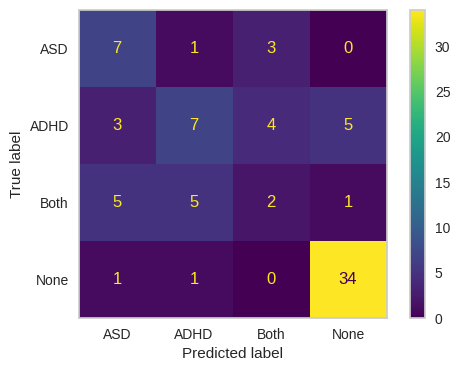

In [ ]:
fig1, ax1 = plt.subplots(figsize=(6, 4))
cmp = ConfusionMatrixDisplay(confusion_matrix(fourwayy_val3, fourwaypred3), display_labels=["ASD", "ADHD", "Both", "None"],)

cmp.plot(ax=ax1)
ax1.grid(False)
plt.show()

In [ ]:
classes_comb = [[0,1], [0,2], [0,3], [1,2], [1,3], [2,3]]
class_list = list(fourway_dt3.classes_)
class_list

[0, 1, 2, 3]

In [ ]:
def calculate_tpr_fpr(y_real, y_pred):

    # Calculates the confusion matrix and recover each element
    cm = confusion_matrix(y_real, y_pred)
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TP = cm[1, 1]

    # Calculates tpr and fpr
    tpr =  TP/(TP + FN) # sensitivity - true positive rate
    fpr = 1 - TN/(TN+FP) # 1-specificity - false positive rate

    return tpr, fpr

In [ ]:
def get_all_roc_coordinates(y_real, y_proba):

    tpr_list = [0]
    fpr_list = [0]
    for i in range(len(y_proba)):
        threshold = y_proba[i]
        y_pred = y_proba >= threshold
        tpr, fpr = calculate_tpr_fpr(y_real, y_pred)
        tpr_list.append(tpr)
        fpr_list.append(fpr)
    return tpr_list, fpr_list

In [ ]:
def plot_roc_curve(tpr, fpr, scatter = True, ax = None):

    if ax == None:
        plt.figure(figsize = (5, 5))
        ax = plt.axes()

    if scatter:
        sns.scatterplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = [0, 1], y = [0, 1], color = 'green', ax = ax)
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

In [ ]:
plt.figure(figsize = (12, 7))
bins = [i/20 for i in range(20)] + [1]
roc_auc_ovo = {}

for i in range(len(classes_comb)):
    # Gets the class
    comb = classes_comb[i]
    c1 = comb[0]
    c2 = comb[1]
    c1_index = class_list.index(c1)
    title = str(c1) + " vs " + str(c2)

    # Prepares an auxiliar dataframe to help with the plots
    df_aux = fourwayx_val3.copy()
    df_aux['class'] = fourwayy_val3
    df_aux['prob'] = fourway_dt3.predict_proba(fourwayx_val3)[:, c1_index]

    # Slices only the subset with both classes
    df_aux = df_aux[(df_aux['class'] == c1) | (df_aux['class'] == c2)]
    df_aux['class'] = [1 if y == c1 else 0 for y in df_aux['class']]
    df_aux = df_aux.reset_index(drop = True)

    # Plots the probability distribution for the class and the rest
    ax = plt.subplot(2, 6, i+1)
    sns.histplot(x = "prob", data = df_aux, hue = 'class', color = 'b', ax = ax, bins = bins)
    ax.set_title(title)
    ax.legend([f"Class 1: {c1}", f"Class 0: {c2}"])
    ax.set_xlabel(f"P(x = {c1})")

    # Calculates the ROC Coordinates and plots the ROC Curves
    ax_bottom = plt.subplot(2, 6, i+7)
    tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
    plot_roc_curve(tpr, fpr, scatter = False, ax = ax_bottom)
    ax_bottom.set_title("ROC Curve OvO")

    # Calculates the ROC AUC OvO
    roc_auc_ovo[title] = roc_auc_score(df_aux['class'], df_aux['prob'])

plt.tight_layout()

## Trying combining all the features

In [ ]:
fe1 = ['MEMORYCOND', 'WALKSTAIRS',  'K6Q71_R', 'K7Q84_R', 'K7Q85_R', 'K7Q70_R', 'MAKEFRIEND', 'K2Q35A', 'K2Q31A']

fe2 = ['K6Q13A', 'K6Q13B', 'K6Q71_R', 'COORDINATION', 'K6Q70_R', 'K6Q73_R', 'K6Q72_R', 'K2Q35A', 'K2Q31A']

fe3 = ['K6Q71_R', 'MAKEFRIEND', 'COORDINATION', 'K6Q70_R', 'K6Q73_R', 'K6Q72_R', 'RECOGBEGIN', 'RECOGABC', 'CLEAREXP',
         'WRITENAME', 'DISTRACTED', 'PLAYWELL', 'HURTSAD', 'K2Q35A', 'K2Q31A']

In [ ]:
fin_fe13 = ['SC_AGE_YEARS', 'SC_SEX', 'K2Q30A', 'K2Q31A', 'K2Q32A', 'K2Q33A','K2Q34A', 'K2Q35A', 'K2Q36A', 'K2Q37A', 'K2Q38A', 'K2Q60A',
       'K6Q71_R', 'MAKEFRIEND', 'COORDINATION', 'K6Q70_R', 'K6Q73_R', 'K6Q72_R', 'RECOGBEGIN', 'RECOGABC',
       'CLEAREXP', 'WRITENAME', 'DISTRACTED', 'PLAYWELL', 'HURTSAD','MEMORYCOND', 'WALKSTAIRS','K7Q84_R', 'K7Q85_R','K7Q70_R']

In [ ]:
t1 = up1[(up1['MEMORYCOND'].notna()) & (up1['WALKSTAIRS'].notna()) & (up1['K6Q71_R'].notna()) & (up1['K7Q84_R'].notna()) & (up1['K7Q85_R'].notna()) &
           (up1['K7Q70_R'].notna()) & (up1['MAKEFRIEND'].notna())][fin_fe13]

print(t1.shape)

#t1.isna().sum()/t1.shape[0]

(177356, 30)


In [ ]:
t1['K2Q35A'].value_counts()

2.0    170916
1.0      6440
Name: K2Q35A, dtype: int64

In [ ]:
t1['K2Q31A'].value_counts()

2.0    152532
1.0     24824
Name: K2Q31A, dtype: int64

In [ ]:
t1[(t1['K2Q35A'] == 1) & (t1['K2Q31A']==1)].value_counts()

Series([], dtype: int64)

In [ ]:
t1_asd = t1[t1['K2Q35A']==1]
t1_adhd = t1[t1['K2Q31A']==1]
t1_none = t1[(t1['K2Q30A'] == 2) & (t1['K2Q31A'] == 2) & (t1['K2Q32A'] == 2) & (t1['K2Q33A'] == 2) &(t1['K2Q34A'] == 2) &
             (t1['K2Q35A'] == 2) & (t1['K2Q36A'] == 2) & (t1['K2Q37A'] == 2) & (t1['K2Q38A'] == 2) & (t1['K2Q60A'] == 2)]

In [ ]:
z1 = pd.concat([t1_asd.sample(425, random_state=2), t1_adhd.sample(425, random_state=5), t1_none.sample(850, random_state=4)])
z1 = z1.sample(frac=1)
z1.isna().sum()/z1.shape[0]

SC_AGE_YEARS    0.0
SC_SEX          0.0
K2Q30A          0.0
K2Q31A          0.0
K2Q32A          0.0
K2Q33A          0.0
K2Q34A          0.0
K2Q35A          0.0
K2Q36A          0.0
K2Q37A          0.0
K2Q38A          0.0
K2Q60A          0.0
K6Q71_R         0.0
MAKEFRIEND      0.0
COORDINATION    1.0
K6Q70_R         1.0
K6Q73_R         1.0
K6Q72_R         1.0
RECOGBEGIN      1.0
RECOGABC        1.0
CLEAREXP        1.0
WRITENAME       1.0
DISTRACTED      1.0
PLAYWELL        1.0
HURTSAD         1.0
MEMORYCOND      0.0
WALKSTAIRS      0.0
K7Q84_R         0.0
K7Q85_R         0.0
K7Q70_R         0.0
dtype: float64

In [ ]:
t3 = up1[(up1['K6Q71_R'].notna()) & (up1['MAKEFRIEND'].notna()) & (up1['K6Q14A'].notna()) & (up1['K6Q14B'].notna()) & (up1['COORDINATION'].notna()) &
         (up1['K6Q70_R'].notna()) & (up1['K6Q73_R'].notna()) & (up1['K6Q72_R'].notna()) & (up1['RECOGBEGIN'].notna()) & (up1['RECOGABC'].notna()) &
         (up1['CLEAREXP'].notna()) & (up1['WRITENAME'].notna()) & (up1['DISTRACTED'].notna()) & (up1['PLAYWELL'].notna()) & (up1['HURTSAD'].notna())][fin_fe13]

print(t3.shape)
#t3.isna().sum()/t3.shape[0]

(12129, 30)


In [ ]:
t3['K2Q35A'].value_counts()

2.0    11577
1.0      552
Name: K2Q35A, dtype: int64

In [ ]:
t3['K2Q31A'].value_counts()

2.0    11704
1.0      425
Name: K2Q31A, dtype: int64

In [ ]:
t3[(t3['K2Q35A'] == 1) & (t3['K2Q31A']==1)].value_counts()

Series([], dtype: int64)

In [ ]:
t3_asd = t3[t3['K2Q35A']==1]
t3_adhd = t3[t3['K2Q31A']==1]
t3_none = t3[(t3['K2Q30A'] == 2) & (t3['K2Q31A'] == 2) & (t3['K2Q32A'] == 2) & (t3['K2Q33A'] == 2) &(t3['K2Q34A'] == 2) &
             (t3['K2Q35A'] == 2) & (t3['K2Q36A'] == 2) & (t3['K2Q37A'] == 2) & (t3['K2Q38A'] == 2) & (t3['K2Q60A'] == 2)]

In [ ]:
z3 = pd.concat([t3_asd.sample(425, random_state=2), t3_adhd, t3_none.sample(850, random_state=4)])
z3 = z3.sample(frac=1)
z3.isna().sum()/z3.shape[0]

SC_AGE_YEARS    0.0
SC_SEX          0.0
K2Q30A          0.0
K2Q31A          0.0
K2Q32A          0.0
K2Q33A          0.0
K2Q34A          0.0
K2Q35A          0.0
K2Q36A          0.0
K2Q37A          0.0
K2Q38A          0.0
K2Q60A          0.0
K6Q71_R         0.0
MAKEFRIEND      0.0
COORDINATION    0.0
K6Q70_R         0.0
K6Q73_R         0.0
K6Q72_R         0.0
RECOGBEGIN      0.0
RECOGABC        0.0
CLEAREXP        0.0
WRITENAME       0.0
DISTRACTED      0.0
PLAYWELL        0.0
HURTSAD         0.0
MEMORYCOND      1.0
WALKSTAIRS      1.0
K7Q84_R         1.0
K7Q85_R         1.0
K7Q70_R         1.0
dtype: float64

In [ ]:
z13_comb = pd.concat([z1, z3])
z13_comb = z13_comb.sample(frac=1)
z13_comb

SC_AGE_YEARS  SC_SEX  K2Q30A  K2Q31A  K2Q32A  K2Q33A  K2Q34A  K2Q35A  \
135693           5.0     1.0     2.0     2.0     2.0     1.0     1.0     1.0   
46251           17.0     1.0     2.0     2.0     2.0     2.0     2.0     2.0   
193658           4.0     2.0     2.0     2.0     2.0     2.0     2.0     2.0   
178515          17.0     1.0     2.0     1.0     2.0     2.0     2.0     2.0   
120789           8.0     2.0     2.0     1.0     1.0     1.0     1.0     2.0   
...              ...     ...     ...     ...     ...     ...     ...     ...   
204318           3.0     1.0     1.0     2.0     2.0     2.0     1.0     1.0   
182836           4.0     2.0     1.0     2.0     2.0     2.0     2.0     1.0   
111720           4.0     1.0     2.0     2.0     2.0     2.0     2.0     2.0   
163307          17.0     1.0     2.0     2.0     2.0     2.0     2.0     1.0   
16430           15.0     2.0     2.0     2.0     2.0     2.0     2.0     2.0   

        K2Q36A  K2Q37A  ...  CLEAREXP  WRITENAME  DISTRACTED  PLAYWELL  \
135693     1.0     2.0  ...       2.0        1.0         4.0       4.0   
46251      2.0     2.0  ...       NaN        NaN         NaN       NaN   
193658     2.0     2.0  ...       2.0        5.0         3.0       2.0   
178515     2.0     2.0  ...       NaN        NaN         NaN       NaN   
120789     1.0     2.0  ...       NaN        NaN         NaN       NaN   
...        ...     ...  ...       ...        ...         ...       ...   
204318     1.0     1.0  ...       4.0        5.0         3.0       4.0   
182836     1.0     2.0  ...       4.0        4.0         3.0       2.0   
111720     2.0     2.0  ...       2.0        1.0         3.0       1.0   
163307     2.0     2.0  ...       NaN        NaN         NaN       NaN   
16430      2.0     2.0  ...       NaN        NaN         NaN       NaN   

        HURTSAD  MEMORYCOND  WALKSTAIRS  K7Q84_R  K7Q85_R  K7Q70_R  
135693      2.0         NaN         NaN      NaN      NaN      NaN  
46251       NaN         2.0         2.0      1.0      1.0      2.0  
193658      1.0         NaN         NaN      NaN      NaN      NaN  
178515      NaN         2.0         2.0      1.0      2.0      3.0  
120789      NaN         1.0         2.0      4.0      4.0      1.0  
...         ...         ...         ...      ...      ...      ...  
204318      2.0         NaN         NaN      NaN      NaN      NaN  
182836      3.0         NaN         NaN      NaN      NaN      NaN  
111720      1.0         NaN         NaN      NaN      NaN      NaN  
163307      NaN         2.0         2.0      1.0      1.0      3.0  
16430       NaN         2.0         2.0      1.0      1.0      3.0  

[3400 rows x 30 columns]

In [ ]:
#float_cols = z13_comb.select_dtypes(include=[np.number, 'float64']).columns.to_list()

In [ ]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=6)

df_filled = imputer.fit_transform(z13_comb)

In [ ]:
imputed_df = pd.DataFrame(df_filled, columns = z13_comb.columns)

#imputed_df.isna().any()

In [ ]:
dev_imp = imputed_df[(imputed_df['K2Q30A'] == 1) | (imputed_df['K2Q31A'] == 1) | (imputed_df['K2Q32A'] == 1) | (imputed_df['K2Q33A'] == 1) |
                     (imputed_df['K2Q34A'] == 1) | (imputed_df['K2Q35A'] == 1) | (imputed_df['K2Q36A'] == 1) | (imputed_df['K2Q37A'] == 1) |
                     (imputed_df['K2Q38A'] == 1) | (imputed_df['K2Q60A'] == 1)]
dev_imp['is_any_disab'] = 1

no_dev_imp = imputed_df[(imputed_df['K2Q30A'] == 2) & (imputed_df['K2Q31A'] == 2) & (imputed_df['K2Q32A'] == 2) & (imputed_df['K2Q33A'] == 2) &
                        (imputed_df['K2Q34A'] == 2) & (imputed_df['K2Q35A'] == 2) & (imputed_df['K2Q36A'] == 2) & (imputed_df['K2Q37A'] == 2) &
                        (imputed_df['K2Q38A'] == 2) & (imputed_df['K2Q60A'] == 2)]
no_dev_imp['is_any_disab'] = 0


print(dev_imp.shape, no_dev_imp.shape)

(1700, 31) (1700, 31)


<ipython-input-87-5a8217e54358>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dev_imp['is_any_disab'] = 1
<ipython-input-87-5a8217e54358>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_dev_imp['is_any_disab'] = 0


In [ ]:
all_del_imp = pd.concat([dev_imp, no_dev_imp])
all_del_imp = all_del_imp.sample(frac=1)
#all_del_imp.reset_index(drop=True, inplace=True)

In [ ]:
all_del_imp.columns.values

array(['SC_AGE_YEARS', 'SC_SEX', 'K2Q30A', 'K2Q31A', 'K2Q32A', 'K2Q33A',
       'K2Q34A', 'K2Q35A', 'K2Q36A', 'K2Q37A', 'K2Q38A', 'K2Q60A',
       'K6Q71_R', 'MAKEFRIEND', 'COORDINATION', 'K6Q70_R', 'K6Q73_R',
       'K6Q72_R', 'RECOGBEGIN', 'RECOGABC', 'CLEAREXP', 'WRITENAME',
       'DISTRACTED', 'PLAYWELL', 'HURTSAD', 'MEMORYCOND', 'WALKSTAIRS',
       'K7Q84_R', 'K7Q85_R', 'K7Q70_R', 'is_any_disab'], dtype=object)

In [ ]:
all_del_imp[['SC_AGE_YEARS', 'SC_SEX', 'K6Q71_R', 'MAKEFRIEND', 'COORDINATION', 'K6Q70_R', 'K6Q73_R', 'K6Q72_R', 'RECOGBEGIN',
             'RECOGABC', 'CLEAREXP', 'WRITENAME', 'DISTRACTED', 'PLAYWELL', 'HURTSAD', 'MEMORYCOND', 'WALKSTAIRS',
             'K7Q84_R', 'K7Q85_R', 'K7Q70_R']].corr().style.background_gradient(cmap='coolwarm')

In [ ]:
any_delay_imp_X1 = all_del_imp[['SC_AGE_YEARS', 'SC_SEX', 'K6Q71_R', 'MAKEFRIEND', 'COORDINATION', 'K6Q70_R', 'K6Q73_R', 'K6Q72_R', 'RECOGBEGIN',
                                'RECOGABC', 'CLEAREXP', 'WRITENAME', 'DISTRACTED', 'PLAYWELL', 'HURTSAD', 'MEMORYCOND', 'WALKSTAIRS',
                                'K7Q84_R', 'K7Q85_R', 'K7Q70_R']]
any_delay_imp_Y1 = all_del_imp['is_any_disab']

In [ ]:
any_del_imp_X_tr1, any_del_imp_X_test1, any_del_imp_Y_tr1, any_del_imp_Y_test1 = train_test_split(any_delay_imp_X1, any_delay_imp_Y1,
                                                                                                  random_state=42, test_size=0.10, shuffle=True)

any_del_imp_xtr1, any_del_imp_xval1, any_del_imp_ytr1, any_del_imp_yval1 = train_test_split(any_del_imp_X_tr1, any_del_imp_Y_tr1,
                                                                                            random_state=42, test_size=0.10, shuffle=True)

In [ ]:
lr_model.fit(any_del_imp_xtr1, any_del_imp_ytr1)

imp_ypr1 = lr_model.predict(any_del_imp_xval1)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
print("Accuracy = ", accuracy_score(any_del_imp_yval1, imp_ypr1))
print("Precision score: ", precision_score(any_del_imp_yval1, imp_ypr1))
print("Recall (sensitivity)): ", recall_score(any_del_imp_yval1, imp_ypr1))
print("Specificity: ", recall_score(any_del_imp_yval1, imp_ypr1, pos_label=0))

print("F1-score: ", f1_score(any_del_imp_yval1, imp_ypr1))
print(f"ROC AUC: {roc_auc_score(any_del_imp_yval1, imp_ypr1)}\n")
print(classification_report(any_del_imp_yval1, imp_ypr1))

Accuracy =  0.9575163398692811
Precision score:  0.9745222929936306
Recall (sensitivity)):  0.9444444444444444
Specificity:  0.9722222222222222
F1-score:  0.9592476489028213
ROC AUC: 0.9583333333333333

              precision    recall  f1-score   support

           0       0.94      0.97      0.96       144
           1       0.97      0.94      0.96       162

    accuracy                           0.96       306
   macro avg       0.96      0.96      0.96       306
weighted avg       0.96      0.96      0.96       306



In [ ]:
imp_test4 = lr_model.predict(any_del_imp_X_test1)

print("Accuracy = ", accuracy_score(any_del_imp_Y_test1, imp_test4))
print("Precision score: ", precision_score(any_del_imp_Y_test1, imp_test4))
print("Recall (sensitivity)): ", recall_score(any_del_imp_Y_test1, imp_test4))
print("Specificity: ", recall_score(any_del_imp_Y_test1, imp_test4, pos_label=0))

print("F1-score: ", f1_score(any_del_imp_Y_test1, imp_test4))
print(f"ROC AUC: {roc_auc_score(any_del_imp_Y_test1, imp_test4)}\n")
print(classification_report(any_del_imp_Y_test1, imp_test4))

Accuracy =  0.9382352941176471
Precision score:  0.9415204678362573
Recall (sensitivity)):  0.936046511627907
Specificity:  0.9404761904761905
F1-score:  0.9387755102040817
ROC AUC: 0.9382613510520487

              precision    recall  f1-score   support

           0       0.93      0.94      0.94       168
           1       0.94      0.94      0.94       172

    accuracy                           0.94       340
   macro avg       0.94      0.94      0.94       340
weighted avg       0.94      0.94      0.94       340



### ASD or ADHD vs None

In [ ]:
## testing ASD or ADHD vs none

imp_asd_adhd = imputed_df[(imputed_df['K2Q35A']==1) | (imputed_df['K2Q31A']==1)]
imp_asd_adhd['target']=1

imp_none = imputed_df[(imputed_df['K2Q30A'] == 2) & (imputed_df['K2Q31A'] == 2) & (imputed_df['K2Q32A'] == 2) & (imputed_df['K2Q33A'] == 2) &
                      (imputed_df['K2Q34A'] == 2) & (imputed_df['K2Q35A'] == 2) & (imputed_df['K2Q36A'] == 2) & (imputed_df['K2Q37A'] == 2) &
                      (imputed_df['K2Q38A'] == 2) & (imputed_df['K2Q60A'] == 2)]
imp_none['target']=0

print(imp_asd_adhd.shape, imp_none.shape)

(1700, 31) (1700, 31)


<ipython-input-19-d1e52ac8f4f1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imp_asd_adhd['target']=1
<ipython-input-19-d1e52ac8f4f1>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imp_none['target']=0


In [ ]:
imp_bincl = pd.concat([imp_asd_adhd, imp_none])
imp_bincl = imp_bincl.sample(frac=1)

In [ ]:
imp_bincl.shape

(3400, 31)

In [ ]:
imp_bincl.columns.values

array(['SC_AGE_YEARS', 'SC_SEX', 'K2Q30A', 'K2Q31A', 'K2Q32A', 'K2Q33A',
       'K2Q34A', 'K2Q35A', 'K2Q36A', 'K2Q37A', 'K2Q38A', 'K2Q60A',
       'K6Q71_R', 'MAKEFRIEND', 'COORDINATION', 'K6Q70_R', 'K6Q73_R',
       'K6Q72_R', 'RECOGBEGIN', 'RECOGABC', 'CLEAREXP', 'WRITENAME',
       'DISTRACTED', 'PLAYWELL', 'HURTSAD', 'MEMORYCOND', 'WALKSTAIRS',
       'K7Q84_R', 'K7Q85_R', 'K7Q70_R', 'target'], dtype=object)

In [ ]:
impX = imp_bincl[['SC_AGE_YEARS', 'SC_SEX', 'K6Q71_R', 'MAKEFRIEND', 'COORDINATION', 'K6Q70_R', 'K6Q73_R', 'K6Q72_R', 'RECOGBEGIN',
                  'RECOGABC', 'CLEAREXP', 'WRITENAME', 'DISTRACTED', 'PLAYWELL', 'HURTSAD', 'MEMORYCOND', 'WALKSTAIRS', 'K7Q84_R', 'K7Q85_R', 'K7Q70_R']]
impY = imp_bincl['target']

impX_tr, impX_test, impY_tr, impY_test = train_test_split(impX, impY, random_state=2, test_size=0.10, shuffle=True)
impx_train, impx_val, impy_train, impy_val = train_test_split(impX_tr, impY_tr, random_state=4, test_size=0.10, shuffle=True)

In [ ]:
dt_model.fit(impx_train, impy_train)

imp_asd_adhd_pred = dt_model.predict(impx_val)

In [ ]:
print("Accuracy = ", accuracy_score(impy_val, imp_asd_adhd_pred))
print("Precision score: ", precision_score(impy_val, imp_asd_adhd_pred))
print("Recall (sensitivity)): ", recall_score(impy_val, imp_asd_adhd_pred))
print("Specificity: ", recall_score(impy_val, imp_asd_adhd_pred, pos_label=0))

print("F1-score: ", f1_score(impy_val, imp_asd_adhd_pred))
print(f"ROC AUC: {roc_auc_score(impy_val, imp_asd_adhd_pred)}\n")
print(classification_report(impy_val, imp_asd_adhd_pred))

Accuracy =  0.9281045751633987
Precision score:  0.9621212121212122
Recall (sensitivity)):  0.8819444444444444
Specificity:  0.9691358024691358
F1-score:  0.9202898550724637
ROC AUC: 0.9255401234567902

              precision    recall  f1-score   support

           0       0.90      0.97      0.93       162
           1       0.96      0.88      0.92       144

    accuracy                           0.93       306
   macro avg       0.93      0.93      0.93       306
weighted avg       0.93      0.93      0.93       306



In [ ]:
cm = confusion_matrix(impy_val, imp_asd_adhd_pred)

TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]
TP = cm[1, 1]

# Calculates tpr and fpr
tpr =  TP/(TP + FN)      # sensitivity - true positive rate
fpr = 1 - TN/(TN+FP)     # 1 - specificity

print(tpr, 1-fpr)

0.8819444444444444 0.9691358024691358


<Axes: ylabel='None'>

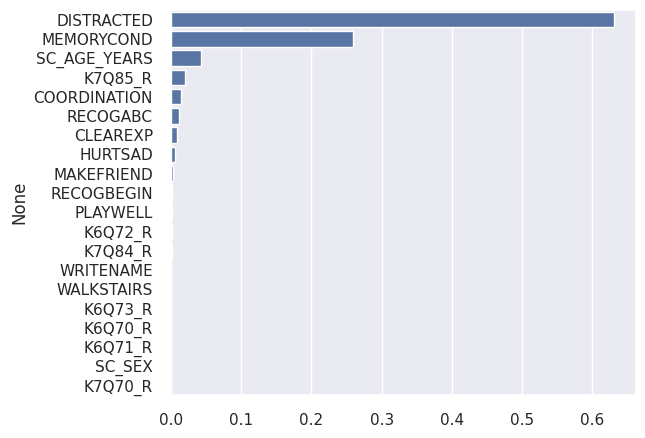

In [ ]:
imp_featimportance = dt_model.feature_importances_

sortidx = imp_featimportance.argsort()[::-1]
sortfeat = impx_val.columns[sortidx]
sorted_imp = imp_featimportance[sortidx]

sns.set(rc={'figure.figsize':(6,5)})
sns.barplot(x=sorted_imp, y=sortfeat)

In [ ]:
lr_model.fit(impx_train, impy_train)

imp_asd_adhd_logpred = lr_model.predict(impx_val)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
print("Accuracy = ", accuracy_score(impy_val, imp_asd_adhd_logpred))
print("Precision score: ", precision_score(impy_val, imp_asd_adhd_logpred))
print("Recall (sensitivity)): ", recall_score(impy_val, imp_asd_adhd_logpred))
print("Specificity: ", recall_score(impy_val, imp_asd_adhd_logpred, pos_label=0))

print("F1-score: ", f1_score(impy_val, imp_asd_adhd_logpred))
print(f"ROC AUC: {roc_auc_score(impy_val, imp_asd_adhd_logpred)}\n")
print(classification_report(impy_val, imp_asd_adhd_logpred))

Accuracy =  0.9313725490196079
Precision score:  0.9624060150375939
Recall (sensitivity)):  0.8888888888888888
Specificity:  0.9691358024691358
F1-score:  0.924187725631769
ROC AUC: 0.9290123456790124

              precision    recall  f1-score   support

           0       0.91      0.97      0.94       162
           1       0.96      0.89      0.92       144

    accuracy                           0.93       306
   macro avg       0.93      0.93      0.93       306
weighted avg       0.93      0.93      0.93       306



<Axes: ylabel='Feature'>

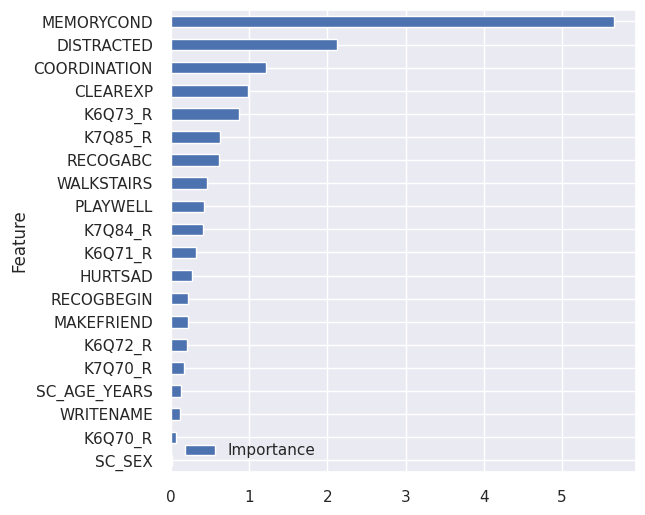

In [ ]:
imp_log_coef = lr_model.coef_[0]

imp_lr_featimp = pd.DataFrame({'Feature': impx_val.columns, 'Importance': np.abs(imp_log_coef)})
imp_lr_featimp = imp_lr_featimp.sort_values('Importance', ascending=True)
imp_lr_featimp.plot(x='Feature', y='Importance', kind='barh', figsize=(6, 6))

In [ ]:
imp_asd_adhd_testpred = lr_model.predict(impX_test)

print("Accuracy = ", accuracy_score(impY_test, imp_asd_adhd_testpred))
print("Precision score: ", precision_score(impY_test, imp_asd_adhd_testpred))
print("Recall (sensitivity)): ", recall_score(impY_test, imp_asd_adhd_testpred))
print("Specificity: ", recall_score(impY_test, imp_asd_adhd_testpred, pos_label=0))

print("F1-score: ", f1_score(impY_test, imp_asd_adhd_testpred))
print(f"ROC AUC: {roc_auc_score(impY_test, imp_asd_adhd_testpred)}\n")
print(classification_report(impY_test, imp_asd_adhd_testpred))

Accuracy =  0.9352941176470588
Precision score:  0.9454545454545454
Recall (sensitivity)):  0.9230769230769231
Specificity:  0.9473684210526315
F1-score:  0.9341317365269461
ROC AUC: 0.9352226720647774

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       171
           1       0.95      0.92      0.93       169

    accuracy                           0.94       340
   macro avg       0.94      0.94      0.94       340
weighted avg       0.94      0.94      0.94       340



In [ ]:
impx_train.columns.values

array(['SC_AGE_YEARS', 'SC_SEX', 'K6Q71_R', 'MAKEFRIEND', 'COORDINATION',
       'K6Q70_R', 'K6Q73_R', 'K6Q72_R', 'RECOGBEGIN', 'RECOGABC',
       'CLEAREXP', 'WRITENAME', 'DISTRACTED', 'PLAYWELL', 'HURTSAD',
       'MEMORYCOND', 'WALKSTAIRS', 'K7Q84_R', 'K7Q85_R', 'K7Q70_R'],
      dtype=object)

In [ ]:
feat_dt_model = DecisionTreeClassifier(max_depth=5)
feat_auc = []
#err_rate = []

for c in range(len(impx_train.columns)):
  dum_xtr = impx_train.iloc[:, 0:c+1]
  dum_xval = impx_val.iloc[:, 0:c+1]
  feat_dt_model.fit(dum_xtr, impy_train)
  dum_pred = feat_dt_model.predict_proba(dum_xval)[:, 1]
  feat_auc.append(roc_auc_score(impy_val, dum_pred))

Text(0, 0.5, 'ROC AUC score')

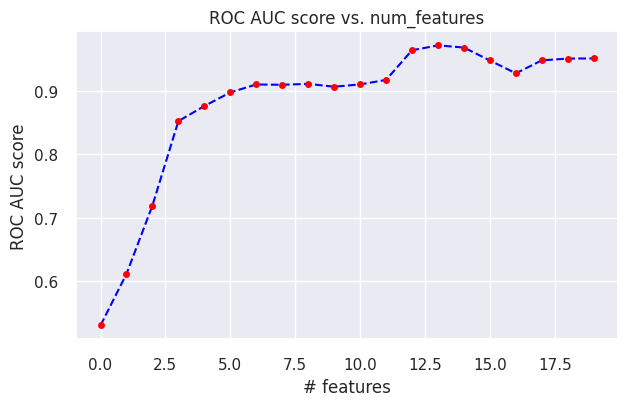

In [ ]:
plt.figure(figsize=(7,4))
plt.plot(range(len(impx_train.columns)),feat_auc, color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=5)
plt.title('ROC AUC score vs. num_features')
plt.xlabel('# features')
plt.ylabel('ROC AUC score')

In [ ]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

## Trying forward feature selection
sfs = SFS(RandomForestClassifier(n_estimators=10, random_state=10),
          k_features=12,
          forward='True',
          scoring='roc_auc',
          verbose=2)

In [ ]:
sfs.fit(impx_train, impy_train)


[2024-03-15 00:32:39] Features: 1/12 -- score: 0.9240005945848342
[2024-03-15 00:32:42] Features: 2/12 -- score: 0.9792322785441426
[2024-03-15 00:32:45] Features: 3/12 -- score: 0.9873190384737633
[2024-03-15 00:32:47] Features: 4/12 -- score: 0.988651064109306
[2024-03-15 00:32:50] Features: 5/12 -- score: 0.9928129300398346
[2024-03-15 00:32:52] Features: 6/12 -- score: 0.9921866175639444
[2024-03-15 00:32:56] Features: 7/12 -- score: 0.9931530493164826
[2024-03-15 00:32:58] Features: 8/12 -- score: 0.9938279675055188
[2024-03-15 00:32:59] Features: 9/12 -- score: 0.9942601081418093
[2024-03-15 00:33:01] Features: 10/12 -- score: 0.9951311799405145
[2024-03-15 00:33:03] Features: 11/12 -- score: 0.994637380829156
[2024-03-15 00:33:04] Features: 12/12 -- score: 0.9961017310140011

SequentialFeatureSelector(estimator=RandomForestClassifier(n_estimators=10,
                                                           random_state=10),
                          forward='True', k_features=(12, 12),
                          scoring='roc_auc', verbose=2)

In [ ]:
sfs.k_feature_idx_

(0, 1, 3, 4, 5, 9, 12, 13, 14, 15, 17, 19)

In [ ]:
sfs_feat = impx_train.columns[list(sfs.k_feature_idx_)]
sfs_feat

Index(['SC_AGE_YEARS', 'SC_SEX', 'MAKEFRIEND', 'COORDINATION', 'K6Q70_R',
       'RECOGABC', 'DISTRACTED', 'PLAYWELL', 'HURTSAD', 'MEMORYCOND',
       'K7Q84_R', 'K7Q70_R'],
      dtype='object')

In [ ]:
### training with the previously identified 10 features

rf = RandomForestClassifier(n_estimators=10, random_state=2, max_depth=4)
rf.fit(impx_train[sfs_feat], impy_train)

RandomForestClassifier(max_depth=4, n_estimators=10, random_state=2)

In [ ]:
rf_pred = rf.predict(impx_val[sfs_feat])

print("Accuracy = ", accuracy_score(impy_val, rf_pred))
print("Precision score: ", precision_score(impy_val, rf_pred))
print("Recall (sensitivity)): ", recall_score(impy_val, rf_pred))
print("Specificity: ", recall_score(impy_val, rf_pred, pos_label=0))

print("F1-score: ", f1_score(impy_val, rf_pred))
print(f"ROC AUC: {roc_auc_score(impy_val, rf_pred)}\n")
print(classification_report(impy_val, rf_pred))

Accuracy =  0.9673202614379085
Precision score:  0.9683544303797469
Recall (sensitivity)):  0.9683544303797469
Specificity:  0.9662162162162162
F1-score:  0.9683544303797469
ROC AUC: 0.9672853232979816

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       148
           1       0.97      0.97      0.97       158

    accuracy                           0.97       306
   macro avg       0.97      0.97      0.97       306
weighted avg       0.97      0.97      0.97       306



In [ ]:
rf_testpred = rf.predict(impX_test[sfs_feat])

print("Accuracy = ", accuracy_score(impY_test, rf_testpred))
print("Precision score: ", precision_score(impY_test, rf_testpred))
print("Recall (sensitivity)): ", recall_score(impY_test, rf_testpred))
print("Specificity: ", recall_score(impY_test, rf_testpred, pos_label=0))

print("F1-score: ", f1_score(impY_test, rf_testpred))
print(f"ROC AUC: {roc_auc_score(impY_test, rf_testpred)}\n")
print(classification_report(impY_test, rf_testpred))

Accuracy =  0.9647058823529412
Precision score:  0.9700598802395209
Recall (sensitivity)):  0.9585798816568047
Specificity:  0.9707602339181286
F1-score:  0.9642857142857144
ROC AUC: 0.9646700577874667

              precision    recall  f1-score   support

           0       0.96      0.97      0.97       171
           1       0.97      0.96      0.96       169

    accuracy                           0.96       340
   macro avg       0.96      0.96      0.96       340
weighted avg       0.96      0.96      0.96       340



In [ ]:
## using mutual information gain

mutual_info = mutual_info_classif(impx_train, impy_train)
mutual_info = pd.Series(mutual_info)
mutual_info.index = impx_train.columns
mutual_info.sort_values(ascending=False)

DISTRACTED      0.369864
MEMORYCOND      0.352390
K7Q85_R         0.262937
PLAYWELL        0.245684
CLEAREXP        0.224152
HURTSAD         0.213408
MAKEFRIEND      0.213020
K7Q84_R         0.197841
K6Q73_R         0.188521
RECOGBEGIN      0.130760
WRITENAME       0.116178
K6Q70_R         0.109814
K6Q72_R         0.098649
COORDINATION    0.088412
K6Q71_R         0.073623
K7Q70_R         0.072107
RECOGABC        0.064740
WALKSTAIRS      0.033504
SC_SEX          0.031686
SC_AGE_YEARS    0.000000
dtype: float64

<Axes: >

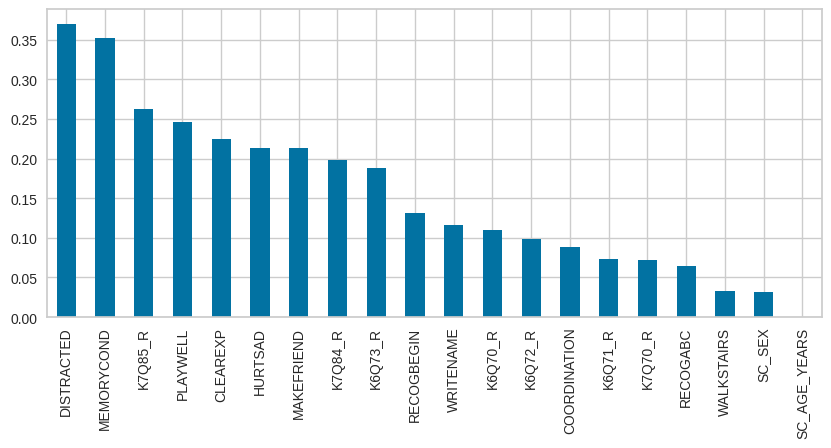

In [ ]:
mutual_info.sort_values(ascending=False).plot.bar(figsize=(10, 4))

In [ ]:
tt1 = up1[(up1['MEMORYCOND'].notna()) | (up1['WALKSTAIRS'].notna()) | (up1['K6Q71_R'].notna()) | (up1['K7Q84_R'].notna()) | (up1['K7Q85_R'].notna()) |
           (up1['K7Q70_R'].notna()) | (up1['MAKEFRIEND'].notna())][fin_fe13]

print(tt1.shape)
tt1.isna().sum()/tt1.shape[0]

(270298, 30)


SC_AGE_YEARS    0.000000
SC_SEX          0.000000
K2Q30A          0.000000
K2Q31A          0.000000
K2Q32A          0.000000
K2Q33A          0.000000
K2Q34A          0.000000
K2Q35A          0.000000
K2Q36A          0.000000
K2Q37A          0.000000
K2Q38A          0.000000
K2Q60A          0.000000
K6Q71_R         0.006067
MAKEFRIEND      0.193612
COORDINATION    0.679835
K6Q70_R         0.679557
K6Q73_R         0.679668
K6Q72_R         0.679265
RECOGBEGIN      0.824594
RECOGABC        0.824394
CLEAREXP        0.824579
WRITENAME       0.824512
DISTRACTED      0.824320
PLAYWELL        0.824442
HURTSAD         0.824224
MEMORYCOND      0.327661
WALKSTAIRS      0.327934
K7Q84_R         0.332344
K7Q85_R         0.331057
K7Q70_R         0.331001
dtype: float64

In [ ]:
chck1 = tt1[(tt1['RECOGBEGIN'].notna()) & (tt1['RECOGABC'].notna()) & (tt1['CLEAREXP'].notna()) & (tt1['WRITENAME'].notna()) &
            (tt1['DISTRACTED'].notna()) & (tt1['PLAYWELL'].notna()) & (tt1['HURTSAD'].notna()) | (tt1['MEMORYCOND'].notna())]

print(chck1.shape)
chck1.isna().sum()/chck1.shape[0]

(228502, 30)


SC_AGE_YEARS    0.000000
SC_SEX          0.000000
K2Q30A          0.000000
K2Q31A          0.000000
K2Q32A          0.000000
K2Q33A          0.000000
K2Q34A          0.000000
K2Q35A          0.000000
K2Q36A          0.000000
K2Q37A          0.000000
K2Q38A          0.000000
K2Q60A          0.000000
K6Q71_R         0.006608
MAKEFRIEND      0.052008
COORDINATION    0.796199
K6Q70_R         0.796024
K6Q73_R         0.796129
K6Q72_R         0.795984
RECOGBEGIN      0.795319
RECOGABC        0.795319
CLEAREXP        0.795319
WRITENAME       0.795319
DISTRACTED      0.795319
PLAYWELL        0.795319
HURTSAD         0.795319
MEMORYCOND      0.204681
WALKSTAIRS      0.207105
K7Q84_R         0.212882
K7Q85_R         0.211359
K7Q70_R         0.211294
dtype: float64

In [ ]:
#tmp1 = up1[up1.index.isin(t1.index)][fin_fe13]
#tmp3 = up1[up1.index.isin(t3.index)][fin_fe13]

# Testing NSDATA

In [ ]:
nsdata = pd.read_sas(mydir+'/nsdata_adhd_puf_u.sas7bdat')
nsdata

IDNUMR  STATE  SAMPLE  SEX  HISPANIC  RACER  AGE_NSDATAR  \
0        38.0    8.0     1.0  2.0       0.0    1.0          3.0   
1        56.0   27.0     1.0  1.0       1.0    1.0          6.0   
2        91.0   24.0     1.0  1.0       0.0    1.0          4.0   
3       201.0   30.0     1.0  1.0       0.0    1.0          6.0   
4       236.0   24.0     1.0  1.0       0.0    1.0          5.0   
...       ...    ...     ...  ...       ...    ...          ...   
2961  95599.0   28.0     1.0  1.0       0.0    1.0          4.0   
2962  95603.0    3.0     2.0  1.0       1.0    1.0          2.0   
2963  95608.0   22.0     1.0  1.0       0.0    1.0          5.0   
2964  95652.0    1.0     1.0  1.0       0.0    1.0          5.0   
2965  95661.0   34.0     1.0  1.0       1.0    1.0          2.0   

      ADHD_A1_AGE_STD  ADHD_A1_1_NEW  ADHD_A1_2  ...  ADHD_G1_4  ADHD_G1_5  \
0                 6.0           10.0        1.0  ...        1.0        0.0   
1                 4.0            9.0        1.0  ...        6.0        0.0   
2                 9.0           10.0        1.0  ...        0.0        0.0   
3                11.0            6.0        1.0  ...        0.0        0.0   
4                10.0            6.0        1.0  ...        1.0        0.0   
...               ...            ...        ...  ...        ...        ...   
2961              5.0            6.0        1.0  ...        0.0        0.0   
2962              5.0            9.0        1.0  ...        0.0        0.0   
2963              3.0            1.0        6.0  ...        0.0        0.0   
2964              8.0            2.0        1.0  ...        0.0        0.0   
2965              6.0            6.0        0.0  ...        0.0        0.0   

      ADHD_G1_6  ADHD_G1_7  ADHD_H1_Q01  ADHD_RELATION  TYPEINS  CONTINS  \
0           0.0        NaN          4.0            1.0      2.0      1.0   
1           0.0        0.0          3.0            2.0      3.0      NaN   
2           0.0        NaN          4.0            1.0      1.0      1.0   
3           0.0        0.0          4.0            1.0      2.0      1.0   
4           0.0        0.0          4.0            2.0      2.0      1.0   
...         ...        ...          ...            ...      ...      ...   
2961        0.0        NaN          4.0            1.0      2.0      1.0   
2962        0.0        NaN          6.0            1.0      1.0      1.0   
2963        0.0        0.0          3.0            1.0      1.0      1.0   
2964        0.0        NaN          5.0            1.0      2.0      1.0   
2965        0.0        NaN          4.0            1.0      2.0      1.0   

      POVLEVEL1_4      ADHD_WT  
0             4.0     8.541671  
1             3.0  1475.878632  
2             2.0   821.790373  
3             3.0   399.167337  
4             3.0   575.109739  
...           ...          ...  
2961          3.0   795.475698  
2962          1.0  8344.500085  
2963          4.0    78.250835  
2964          3.0  1398.064725  
2965          4.0   352.055105  

[2966 rows x 267 columns]